In [15]:
import os
import pickle
import cv2
import numpy as np
import math
import time
import sys 
from scipy.spatial import Voronoi, voronoi_plot_2d

%matplotlib inline
import matplotlib.pyplot as plt
import ipywidgets.widgets as widgets
from IPython.display import display

from jetbot import bgr8_to_jpeg
from jetbot import ObjectDetector
from jetbot import Camera
from jetbot import Robot

### Dijkstra code - for computing shortest path

https://benalexkeen.com/implementing-djikstras-shortest-path-algorithm-with-python/

In [16]:
from collections import defaultdict

class Graph():
    def __init__(self):
        """
        self.edges is a dict of all possible next nodes
        e.g. {'X': ['A', 'B', 'C', 'E'], ...}
        self.weights has all the weights between two nodes,
        with the two nodes as a tuple as the key
        e.g. {('X', 'A'): 7, ('X', 'B'): 2, ...}
        """
        self.edges = defaultdict(list)
        self.weights = {}
    
    def add_edge(self, from_node, to_node, weight):
        # Note: assumes edges are bi-directional
        self.edges[from_node].append(to_node)
        self.edges[to_node].append(from_node)
        self.weights[(from_node, to_node)] = weight
        self.weights[(to_node, from_node)] = weight

def dijsktra(graph, initial, end):
    # shortest paths is a dict of nodes
    # whose value is a tuple of (previous node, weight)
    shortest_paths = {initial: (None, 0)}
    current_node = initial
    visited = set()
    
    while current_node != end:
        visited.add(current_node)
        destinations = graph.edges[current_node]
        weight_to_current_node = shortest_paths[current_node][1]

        for next_node in destinations:
            weight = graph.weights[(current_node, next_node)] + weight_to_current_node
            if next_node not in shortest_paths:
                shortest_paths[next_node] = (current_node, weight)
            else:
                current_shortest_weight = shortest_paths[next_node][1]
                if current_shortest_weight > weight:
                    shortest_paths[next_node] = (current_node, weight)
        
        next_destinations = {node: shortest_paths[node] for node in shortest_paths if node not in visited}
        if not next_destinations:
            return "Route Not Possible"
        # next node is the destination with the lowest weight
        current_node = min(next_destinations, key=lambda k: next_destinations[k][1])
    
    # Work back through destinations in shortest path
    path = []
    while current_node is not None:
        path.append(current_node)
        next_node = shortest_paths[current_node][0]
        current_node = next_node
    # Reverse path
    path = path[::-1]
    return path

## Shared Functions (will be moved to .py files later on)

In [88]:
def distance(pt1, pt2):
    """ Distance between 2 points """
    pt1 = np.array(pt1)
    pt2 = np.array(pt2)
    return np.linalg.norm(pt1-pt2)

def normalize_angle(angle):
    """ Normalize angle to between +pi and -pi """
    """ Important for EKF Correction Step !!!  """
    return (angle+math.pi)%(2*math.pi)-math.pi

""" =================== """        
""" Robot Mobility      """
""" =================== """

def control2robot(wheel_radius, axle_length):
    """ transform wheel speeds to robot motion in world frame """
    l = axle_length
    r = wheel_radius

    return np.array([[r/2, r/2],
                  [r/l, -r/l]])

def omega2speed(in_val, mapping, debug=False):
    """ Map wheel angular speed to motor speed setting based on a calibration mapping """
    
    if in_val < 0:
        sign = -1
        in_val = abs(in_val)
    else:
        sign = 1
        
    out_lower = 0
    in_lower = 0
    out_val = 0

    for i, in_upper in enumerate(mapping["omega"]):
        if debug:
            print (i, in_upper)
        if in_val < in_upper:
            out_upper = mapping["speed"][i]
            out_val = out_lower + (in_val - in_lower)/(in_upper - in_lower) \
                *(out_upper-out_lower)
            if debug:
                print("yes", out_val)
            break
        else:
            if debug:
                print("no")
            out_lower = mapping["speed"][i]
            in_lower = in_upper
            
    if out_val is 0:
        print ("Input is too high!!!", in_val)
        out_val = 0
        
    return sign*out_val

def clamp(wheel_velocities, upper_limit, lower_limit, T, debug=False):
    """ Place limits on motor speed --> improve open-end control reliability """
    
    robot_velocities = np.dot(T, wheel_velocities)  # get (tranl_vel, ang_vel)
    print(robot_velocities)
    tranl_velocity = robot_velocities[0,0]
    
    # Set lower limit on translational speed to 0.15m/s (motor setting 0.3)
    if abs(tranl_velocity) < lower_limit:
        robot_velocities[0,0] = tranl_velocity/abs(tranl_velocity) * lower_limit
        if debug:
            print("Robot speed boosted", robot_velocities) 
    # Set upper limit on translational speed to 0.49m/s (motor setting 0.5)
    elif abs(tranl_velocity) > upper_limit:
        robot_velocities[0,0] = tranl_velocity/abs(tranl_velocity) * upper_limit
        if debug:
            print("Robot speed limited", robot_velocities)
            
    ang_velocity = robot_velocities[1,0]
    ang_upper_limit = 5.0
    if abs(ang_velocity) > ang_upper_limit:
        robot_velocities[1,0] = ang_velocity/abs(ang_velocity) * ang_upper_limit
        if debug:
            print("Rotational speed limited", robot_velocities)
            
    # return clamped wheel velocities
    return np.dot(np.linalg.pinv(T), robot_velocities)

def calc_wheel_velocities(direction='L', arc_radius=0.5, min_ang_vel=3.85, \
       wheel_radius=0.0325, axle_length=0.12, debug = False):
    """ Calculate wheel velocities to generate forward arc motion of provided radius """

    radius = arc_radius
    axle = axle_length
    
    if direction is 'L':
        """ If left turn, angular velocity of right wheel should be higher.
        Set angular velocity of left wheel to minumum (e.g. 3.85--> motor setting of 0.3) """
        l_ang_vel = min_ang_vel
        r_ang_vel = (min_ang_vel*2)/(2*radius/axle-1)+min_ang_vel
    else:
        """ If right turn, angular velocity of left wheel should be higher.
        Set angular velocity of right wheel to minumum (e.g. 3.85--> motor setting of 0.3) """
        r_ang_vel = min_ang_vel    
        l_ang_vel = (min_ang_vel*2)/(2*radius/axle-1)+min_ang_vel
    
    if debug:
        print ("Left angular velocity:",l_ang_vel, " Right angular velocity:",r_ang_vel)
        T = control2robot(wheel_radius, axle_length)
        robot_velocities = np.dot(T, np.array([[r_ang_vel],[l_ang_vel]]))
        print ("Robot velocities:", robot_velocities)
        print("arc radius = ",abs(robot_velocities[0,0]/robot_velocities[1,0]))
    
    return np.array([[r_ang_vel],[l_ang_vel]])

""" =================== """        
""" Camera Functions    """
""" =================== """

def undistort(img, mtx, dist, crop=False):
    """Undistort camera image based on calibration data"""
    h,w = img.shape[:2]
    # print (h,w)
    newcameramtx, roi=cv2.getOptimalNewCameraMatrix(mtx,dist,(w,h),1,(w,h))
    
    # undistort
    dst = cv2.undistort(img, mtx, dist, None, newcameramtx)

    # crop the image (optional)
    if crop:
        x,y,w,h = roi
        dst = dst[y:y+h, x:x+w]
    return dst

def draw_bbox(img, width, height, bbox, color, line_width):
    bbox_pixel = [(int(width * bbox[0]), int(height * bbox[1])), 
                  (int(width * bbox[2]), int(height * bbox[3]))]
    cv2.rectangle(img, bbox_pixel[0], bbox_pixel[1], color, line_width)
    return bbox_pixel

def valid_bbox(bbox, width, height):
    """ Detect if an object borders the 4 edges of the camera image plane. 
    Used to disregard a landmark for range and bearing estimation. """
    return (width * bbox[0]>10) and \
           (width * bbox[2]<width-10) and \
           (height * bbox[1]>10) and \
           (height * bbox[3]<height-10)

def draw_landmarks(img, landmarks, width, height, debug=False):
    """ put blue bounding boxes on detected objects on image """
    
    for item in landmarks:
        label = COCO_labels[item['label']-1]
        bbox = item['bbox']
        bbox_pixel = draw_bbox(img, width, height, bbox, BLUE, 1)
        if debug:
            print(label,item['label'], bbox_pixel)
    return

def landmark_coordinates(item, width, height):
    """ calculate landmark's left, center and right in image pixel coordinates """
    u_left = item['bbox'][0] * width
    u_right = item['bbox'][2] * width
    u_center = (item['bbox'][0]+item['bbox'][2])*width/2
    return u_left, u_center, u_right

""" =================== """        
""" EKF Functions       """
""" =================== """

def initialize_Mu_Sigma(x,y,theta,landmark_list):
    """ Initialize Mu and Sigma """
    # Initialize Mu
    Mu = np.array([[x],[y],[theta]])
    for object in range(len(landmark_list)):
        Mu = np.vstack((Mu,np.array([[0],[0]])))
    N = Mu.shape[0]   # N=3+2n, n=num of landmarks

    # Initialize Sigma - For Σ_mm, infinity (large num) along the diagonal and zero everywhere else 
    Sigma = np.zeros((N,N))
    Sigma[3:,3:] = np.eye(N-3)*LARGE
    
    return Mu, Sigma

def robot_pose_delta(v,w,theta,dt):
    """ Calculate change in robot pose in world frame """
    
    """ An alternate way - can avoid divide by zero error if w is zero
    x_delta = v*dt*math.cos(theta)
    y_delta = v*dt*math.sin(theta)
    """
    arc_radius = v/w   # arc radius
    
    x_delta = arc_radius*(math.sin(theta+w*dt)-math.sin(theta))
    y_delta = arc_radius*(math.cos(theta)-math.cos(theta+w*dt))
    theta_delta = w*dt
    
    return x_delta, y_delta, theta_delta

def compute_G_t(v,w,theta,dt,N):
    """ Calculate G_t matrix """ 
    F = np.zeros((3,N))
    F[0:3,0:3] = np.eye(3)
    
    """ An alternate way to avoid divide by zero error if w is zero """
    """ TBD """
    
    arc_radius = v/w   # arc radius
    
    d_x_delta = arc_radius*(math.cos(theta+w*dt)-math.cos(theta))
    d_y_delta = arc_radius*(-math.sin(theta)+math.sin(theta+w*dt))
    
    G_x_t = np.array([[0,0,d_x_delta],[0,0,d_y_delta],[0,0,0]])
    G_t = np.eye(N)+ np.dot(np.dot(F.T, G_x_t),F)
    
    return G_t

def prediction_step_update(Mu, Sigma, x_delta, y_delta, theta_delta, G_t, R_t, N):
    """
    Implement: 
         Mu_t = g(Mu_t-1, u_t) 
         Sigma_t = G_t.Sigma_t-1.G_t^T + F^T.R_t.F
    """
    F = np.zeros((3,N))
    F[0:3,0:3] = np.eye(3)
    Mu = Mu + np.dot(F.T, np.array([[x_delta],[y_delta],[theta_delta]]))
    Sigma = np.dot(np.dot(G_t, Sigma),G_t.T) + np.dot(np.dot(F.T, R_t),F)
    
    return Mu, Sigma
    
def estimate_range_bearing(landmarks, index, u_l, u_c, u_r, c_u, focal_length,\
                           correct_factor, camera_offset):
    """ Estimate landmark range (r) and bearing (phi) """
    
    j = index  # j is landmark index
    landmark_width = landmarks[j]['width']   # we know landmark's real width
    
    # First calculate range and bearing from camera's focal center
    phi = math.atan2(c_u-u_c, f_u) # phi is +ve if landmark is left of focal center
    depth = f_u/(u_r-u_l)*landmark_width*correct_factor-focal_length
    r = depth/math.cos(phi)

    # Next calculate range and bearing from robot's center of motion
    true_phi = math.atan2(r*math.sin(phi), depth+focal_length+camera_offset)
    true_r = (depth+focal_length+camera_offset)/math.cos(true_phi)
    
    return true_r, true_phi

def update_landmark_Mu(Mu, j, r, phi):
    """ Update j-th landmark's x and y coordinate in Mu """
    
    x = Mu[0,0] 
    y = Mu[1,0] 
    theta = Mu[2,0]
    
    Mu[3+2*j,0] = x + r*math.cos(phi+theta)
    Mu[3+2*j+1,0] = y + r*math.sin(phi+theta)
    
    return Mu

def get_observation(Mu, j):
    """ Get landmark's updated observation """
    robot_x = Mu[0,0] 
    robot_y = Mu[1,0] 
    robot_theta = Mu[2,0]
    landmark_x = Mu[3+2*j,0]
    landmark_y = Mu[3+2*j+1,0]
    delta_x = landmark_x-robot_x
    delta_y = landmark_y-robot_y
    
    delta = np.array([[delta_x],[delta_y]])
    q = np.asscalar(np.dot(delta.T, delta))
    # important to normalize orientation (otherwise fatal error in EKF!!!)
    phi = normalize_angle(math.atan2(delta_y,delta_x)-robot_theta)
    z_t_hat = np.array([[math.sqrt(q)],[phi]])

    return delta, q, z_t_hat

def compute_H_t(delta, j, q, N):             
    """ Compute H_t matrix """     
    delta_x = delta[0,0]
    delta_y = delta[1,0]  
    
    F = np.zeros((5,N))
    F[0:3,0:3] = np.eye(3)
    F[3:5,3+2*j:3+2*j+2] = np.eye(2)
            
    sqrt_q = math.sqrt(q)
    H_j = np.array([[-sqrt_q*delta_x, -sqrt_q*delta_y,   0, sqrt_q*delta_x, sqrt_q*delta_y],
                    [        delta_y,        -delta_x,  -q,       -delta_y,        delta_x]])
    H_t = 1/q*np.dot(H_j,F)
    
    return H_t

def compute_Kalman_Gain(delta, q, j, H_t, Sigma, N, Q_t):
    """ Compute Kalman Gain K_t """         
    delta_x = delta[0,0]
    delta_y = delta[1,0]
            
    # Compute Kalman Gain K_t
    L = np.dot(np.dot(H_t, Sigma),H_t.T) + Q_t
    K_t = np.dot(np.dot(Sigma, H_t.T),np.linalg.inv(L))
    
    return K_t

""" =================== """        
""" Map Generation      """
""" =================== """

def in_blocked_area(blocked, point):
    """ Check if a point falls within a blocked region """
    x,y = point
    ULeft_x, ULeft_y = blocked[0]
    LRight_x, LRight_y = blocked[1]
    
    if (ULeft_x<=x<=LRight_x) and (ULeft_y>=y>=LRight_y):
        return True
    else:
        return False
    
def valid_point(blocked_areas, point):
    """ A point is valid if it does not wihin a list of blocked regions """
    for area in blocked_areas:
        if in_blocked_area(area, point):
            return False

    return True

def display_landmarks(landmarks):
    """ Display landmarks """
    for i, landmark in enumerate(landmarks):
        # Mark landmark's actual locations (red crosses)
        landmark_x_actual = landmark["actual_x"]*100
        landmark_y_actual = landmark["actual_y"]*100
        plt.plot(landmark_x_actual, landmark_y_actual, marker='*', markersize=8, color='red')
        
        # Mark areas blocked by landmarks (blue crosses)
        if landmark["blocked"] is not None:
            plt.scatter(landmark["barrier"][:,0]*100, landmark["barrier"][:,1]*100, marker='*', color='blue')
    return

def display_barriers(barriers):
    """ Display non-landmark blocked regions """
    for barrier in barriers:
        # Mark areas blocked by barriers (blue crosses)
        points = barrier["barrier"]
        plt.scatter(points[:,0]*100, points[:,1]*100, marker='*', color='blue') 
    return

def display_environ(landmarks, barriers, display_param):
    """ Display map of environments - landmarks and blocked regions """
    
    # Load display parameters
    plt.figure(figsize=display_param["figsize"]) 
    plt.xlim(display_param["xlim"]); plt.ylim(display_param["ylim"])

    display_landmarks(landmarks)
    display_barriers(barriers)

    plt.show()
    plt.close()
    
    return

def display_edges(edges, vor):
    """ Display path formed from voronoi vertices """
    x = []
    y = []
    for edge in edges:
        idx1, idx2, _ = edge
        simplex = np.asarray([int(idx1),int(idx2)]) 
        x = vor.vertices[simplex, 0] 
        y = vor.vertices[simplex, 1]
        plt.plot(x,y,'k-', color="black")    
    return

def display_path(path, vor):
    """ Display path formed from voronoi vertices """
    x = []
    y = []
    for pt in path:
        idx = int(pt)
        x.append(vor.vertices[idx, 0])  
        y.append(vor.vertices[idx, 1])
        # print (pt,x,y)
    
    plt.plot(x,y,'k-', color="black")    
    return

def display_voronoi_edges(points, vor, edges, display_param):
    """ Display voronoi diagram - points, vertices and paths """
    
    # Load display parameters
    plt.figure(figsize=display_param["figsize"]) 
    plt.xlim(display_param["xlim"]); plt.ylim(display_param["ylim"])
    
    # Display points and vertices
    plt.plot(points[:, 0], points[:, 1], 'o')
    plt.plot(vor.vertices[:, 0], vor.vertices[:, 1], '*')
    
    # display edges
    display_edges(edges, vor)
    
    plt.show()
    plt.close()
    
    return

def display_voronoi_path(points, vor, path, display_param):
    """ Display voronoi diagram - points, vertices and paths """
    
    # Load display parameters
    plt.figure(figsize=display_param["figsize"]) 
    plt.xlim(display_param["xlim"]); plt.ylim(display_param["ylim"])
    
    # Display points and vertices
    plt.plot(points[:, 0], points[:, 1], 'o')
    plt.plot(vor.vertices[:, 0], vor.vertices[:, 1], '*')
    
    # display path
    display_path(path, vor)
    
    plt.show()
    plt.close()
    
    return

def update_map(Mu, landmarks, Mu_prev=None, folder=None, ind=None, debug=False):
    """ Update robot position on map """
    plt.figure(figsize=(8,8))
    plt.xlim([-100,250])
    plt.ylim([-100,250])
    
    """ Display robot as line + triangle (arrow) """
    robot_x = Mu[0,0]*100
    robot_y = Mu[1,0]*100
    robot_theta = Mu[2,0]*180/math.pi - 90 # Adjust orientation to match matplotlib
    
    if debug:
        print("(x,y):{:.1f}, {:.1f}".format(robot_x,robot_y))
        print("Orientation: {:.1f}".format(normalize_angle(Mu[2,0])*180/math.pi))
    
    # robot = line + triangle
    plt.plot(robot_x, robot_y, marker=(2, 0, robot_theta), c='k',markersize=15, linestyle='None')
    plt.plot(robot_x, robot_y, marker=(3, 0, robot_theta), c='k',markersize=10, linestyle='None')
    
    """ Display landmark as green cross, uncorrected landmark as lime cross """
    for i, landmark in enumerate(landmarks):
        if landmark['observed'] is True:
            # Mark landmark's actual locations
            landmark_x_actual = landmark["actual_x"]*100
            landmark_y_actual = landmark["actual_y"]*100
            plt.plot(landmark_x_actual, landmark_y_actual, marker='*', markersize=8, color='red') 
            # Mark landmark (post-Kalman correction)
            landmark_x = Mu[3+2*i]*100
            landmark_y = Mu[3+2*i+1]*100
            plt.plot(landmark_x, landmark_y,marker='x', markersize=12, color='blue')
            plt.text(landmark_x, landmark_y+10, landmark["obj_name"])
    
    if (folder is not None) and (ind is not None):
        file_path = os.path.join(folder, 'map_'+str(ind+1).zfill(3)+'.png')
        plt.savefig(file_path)
    else:
        plt.show()
        
    plt.close()
    return

## Landmarks and Central Barrier

To be used for generating Voronoi diagrams.

In [74]:
# Landmarks
landmarks = [
    {
    "label": 19,
    "obj_name": 'horse',
    "width": 0.394,
    "observed": False,
    "actual_x": 1.50,
    "actual_y": 1.50,
    "Mu": [],
    "blocked": [[1.3,1.56],[1.7,1.44]],    
    "barrier": np.array([[1.3,1.44],
                    [1.3,1.56],
                    [1.5,1.56],
                    [1.7,1.56],
                    [1.7,1.44],
                    [1.5,1.44]
                   ])
    },
    {
    "label": 44,
    "obj_name": 'bottle',
    "width": 0.10,
    "observed": False,
    "actual_x": 0.75,
    "actual_y": 1.50,
    "Mu": [],
    "blocked": [[0.7,1.55],[0.8,1.45]],    
    "barrier": np.array([[0.8,1.55],
                    [0.8,1.45],
                    [0.7,1.45],
                    [0.7,1.55]
                   ])
    },
    {
    "label": 63,
    "obj_name": 'couch',
    "width": 1.68,
    "observed": False,
    "actual_x": -0.50,
    "actual_y": 1.21,
    "Mu": [],
    "blocked": [[-1.45,2.18],[-0.25,0.5]],    
    "barrier": np.array([[-1.45,2.18],
                    [-0.25,2.18],
                    [-0.25,1.8],                         
                    [-0.25,1.4], 
                    [-0.25,1.0],
                    [-0.25,0.5],
                    [-1.45,0.5],
                    [-1.45,1.34]
                   ])
    },
    {
    "label": 72,
    "obj_name": 'TV',
    "width": 1.00,
    "observed": False,
    "actual_x": 2.0,
    "actual_y": 0.9,
    "Mu": [],
    "blocked": [[1.9,1.5],[2.5,0.25]],    
    "barrier": np.array([[1.9,1.5],
                    [2.5,1.5],
                    [2.5,0.9],
                    [2.5,0.25],
                    [1.9,0.25],
                    [1.9,0.9]
                   ])
    },
    {
    "label": 64,
    "obj_name": 'potted plant',
    "width": 0.55,
    "observed": False,
    "actual_x": 0.5,
    "actual_y": -0.10,
    "Mu": [],
    "blocked": [[0.2,0.1],[0.8,-0.3]],    
    "barrier": np.array([[0.2,0.1],
                    [0.8,0.1],
                    [0.8,-0.3],
                    [0.2,-0.3]
                   ])
    }
]

# Central barrier - 0.5m x 0.5m
barriers = [
    {
    "name": "Central",
    "barrier": np.array([[0.5,0.5],
                    [0.5,0.75],
                    [0.5,1.0],
                    [0.75,1.0],
                    [1.0,1.0],
                    [1.0,0.75],
                    [1.0,0.5],
                    [0.75,0.5]
                   ]),
    "blocked": [[0.5,1.0],[1.0,0.5]]
    }
]

### Plot Map

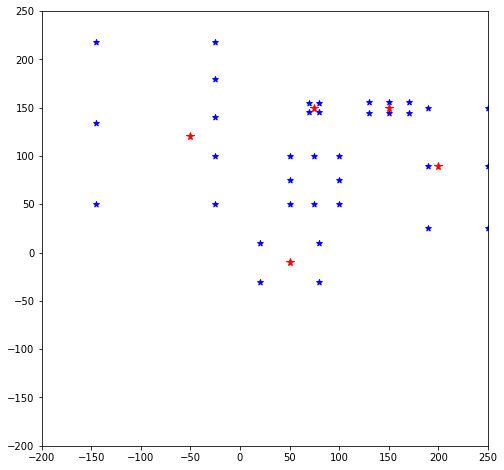

In [59]:
display_param = {
    "figsize": (8,8),
    "xlim": [-200,250],
    "ylim": [-200,250]
    }

display_environ(landmarks, barriers, display_param)

## Voronoi Diagram --> Legal Paths

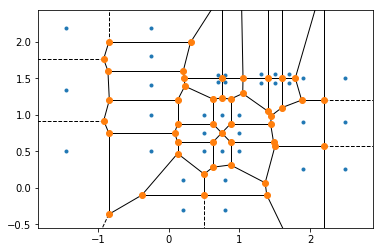

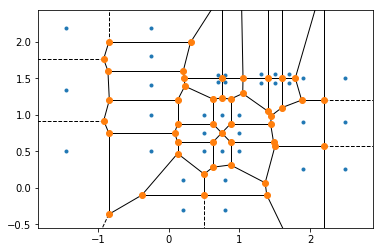

In [60]:
num_pt = 0
for landmark in landmarks:
    landmark_barrier = landmark["barrier"]
    num, _ = landmark_barrier.shape
    num_pt += num

for barrier in barriers:
    num, _ = barrier["barrier"].shape
    num_pt += num
    points = np.zeros((num_pt,2))

# create landmark points
j = 0
for landmark in landmarks:
    landmark_barrier = landmark["barrier"]
    num, _ = landmark_barrier.shape
    for i in range(num):
        points[j,0] = landmark_barrier[i,0]
        points[j,1] = landmark_barrier[i,1]
        j += 1
    
# create barrier points for blocked regions
for barrier in barriers:
    num, _ = barrier["barrier"].shape
    for i in range(num):
        points[j,0] = barrier["barrier"][i,0]
        points[j,1] = barrier["barrier"][i,1]    
        j += 1
    
vor = Voronoi(points)
voronoi_plot_2d(vor)

3 4 [0.30789474 1.99      ] [0.20526316 1.6       ] 0.40327811866902746
7 18 [0.22105263 1.5       ] [0.22679641 1.39086826] 0.10928278398543254
18 19 [0.22679641 1.39086826] [0.625      1.21388889] 0.4357611735325622
19 22 [0.625      1.21388889] [0.75       1.22777778] 0.12576923802968634
4 7 [0.20526316 1.6       ] [0.22105263 1.5       ] 0.10123886348248064
3 8 [0.30789474 1.99      ] [0.75       2.65666667] 0.7999384402292189
25 28 [0.875  0.3125] [0.625   0.28125] 0.25194555463432966
25 27 [0.875  0.3125] [1.36463415 0.06768293] 0.547427617662296
26 27 [ 1.3875 -0.1   ] [1.36463415 0.06768293] 0.16923478133517178
28 29 [0.625   0.28125] [0.5    0.1875] 0.15625
10 11 [1.48333333 0.625     ] [1.50555556 0.575     ] 0.054715876676644834
11 27 [1.50555556 0.575     ] [1.36463415 0.06768293] 0.5265258363132841
1 26 [ 2.2   -1.725] [ 1.3875 -0.1   ] 1.816805231718579
15 16 [-0.38055556 -0.1       ] [0.125   0.46875] 0.7609618796320131
16 29 [0.125   0.46875] [0.5    0.1875] 0.46875
0 1

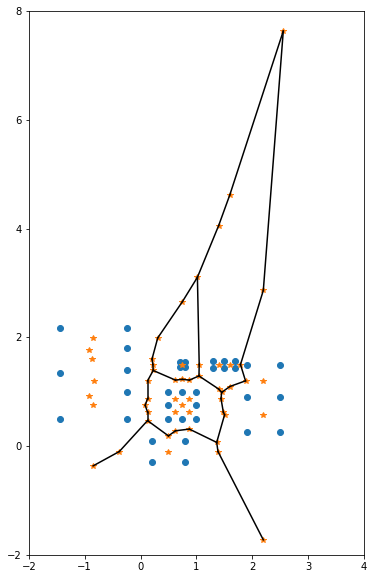

In [61]:
# Build a list of blocked areas
blocked_areas = []
for barrier in barriers:
    blocked_areas.append(barrier["blocked"])
for landmark in landmarks:
    blocked_areas.append(landmark["blocked"])
        
# Graph for shortest distance computation
graph = Graph()
edges = []

# plot parameters
display_param = {
    "figsize": (6,10),
    "xlim": [-2, 4],
    "ylim": [-2, 8]
    }

for simplex in vor.ridge_vertices:
    simplex = np.asarray(simplex)
    start = vor.vertices[simplex[0]]
    end = vor.vertices[simplex[1]]
    
    """ Graph edges connect valid points, which are non-infinity points that are not in any blocked region """ 
    if np.all(simplex >= 0) and (valid_point(blocked_areas,start) and valid_point(blocked_areas,end)):
        dist = np.linalg.norm(start-end)
        edges.append((str(simplex[0]),str(simplex[1]),dist))
        # print out for to keep record
        print(str(simplex[0]),str(simplex[1]), start, end, dist)

display_voronoi_edges(points, vor, edges, display_param)

## Shortest Path Search

['1', '26', '27', '11', '10', '14', '21', '35', '36', '23', '22', '19']


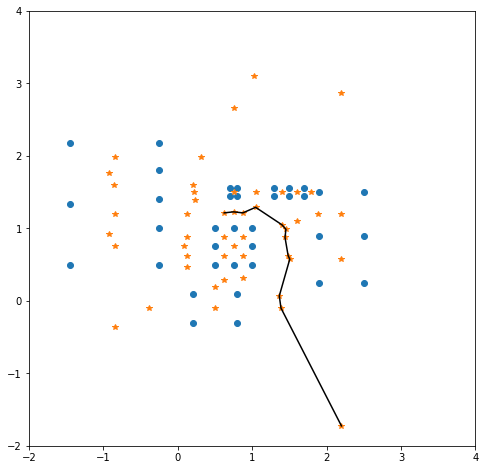

In [64]:
for edge in edges:
    graph.add_edge(*edge)
    
shortest = dijsktra(graph, '1', '19')
print(shortest)

# plot parameters
display_param = {
    "figsize": (8,8),
    "xlim": [-2, 4],
    "ylim": [-2, 4]
    }
display_voronoi_path(points, vor, shortest, display_param)

## Initialize JetBot

In [3]:
model = ObjectDetector('../Notebooks/object_following/ssd_mobilenet_v2_coco.engine')
camera = Camera.instance(width=300, height=300)
robot = Robot()

In [98]:
# Load COCO labels
filename = "coco_labels.dat"
filehandler = open(filename, 'rb')
COCO_labels = pickle.load(filehandler)

# Load camera calibration data for undistort
filename = "calibration.dat"
filehandler = open(filename, 'rb')
camera_cal = pickle.load(filehandler)
mtx = camera_cal['mtx']
dist = camera_cal['dist']
f_u = mtx[0,0]  # focal lengths in u pixels (image plane horizontal)
f_v = mtx[1,1]  # focal lengths in v pixels (image plane vertical)
c_u = mtx[0,2]  # focal center in u pixels (image plane horizontal)
c_v = mtx[1,2]  # focal center in v pixels (image plane vertical)
focal_center = np.array([c_u, c_v])

# Open Image Widget
image_widget = widgets.Image(format='jpeg', width=300, height=300)
width = int(image_widget.width)
height = int(image_widget.height)

BLUE = (255, 0, 0)
GREEN = (0, 255, 0)
RED = (0, 0, 255)

diag_dir = 'diagnostics'
# we have this "try/except" statement because these next functions can throw an error if the directories exist already
try:
    os.makedirs(diag_dir)
except FileExistsError:
    print('Directories not created because they already exist')

# Mapping between set_motor "speed" and measured wheel angular velocity "omega"
# for 0.1 second motor running time
wheel_calibration = {
    "speed": [0.25, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8],
    "omega": [0.0, 3.85, 9.23, 15.0, 25.8, 29.2, 35.4]
}

Directories not created because they already exist


In [83]:
""" ======================== """        
""" Open-End Circular Motion """
""" ======================== """

def take_circ_step(robot_params, direction, radius, debug=False, motion=True):
    """ Open-end control for circular motion - Taking one step in the trajectory """

    # load robot control parameters
    start_x = robot_params["start_x"]
    start_y = robot_params["start_y"]
    wheel_radius = robot_params["wheel_radius"]
    axle_length = robot_params["axle_length"]
    motor_on_time = robot_params["motor_on_time"]
    motor_off_time = robot_params["motor_off_time"]
    min_ang_velocity = robot_params["min_ang_velocity"]
    
    """ Generate clamped wheel velocities based on turn direction and radius """
    wheel_velocities = calc_wheel_velocities(direction='L', arc_radius=radius, \
        min_ang_vel=min_ang_velocity, \
        wheel_radius=wheel_radius, axle_length=axle_length, debug = debug)
    
    """ Map wheel angular velocities to motor setting, then run motors """ 
    w_r = omega2speed(wheel_velocities[0,0],wheel_calibration) 
    w_l = omega2speed(wheel_velocities[1,0],wheel_calibration)
    if debug:
        print ("L motor:", w_l," R motor:", w_r)
    
    """ Run motor step motion """
    if motion:
        robot.set_motors(w_l, w_r)  # left, right
        time.sleep(motor_on_time)
        robot.stop()
        time.sleep(motor_off_time)
    
    return wheel_velocities

(x,y):75.0, 25.0
Orientation: 0.0


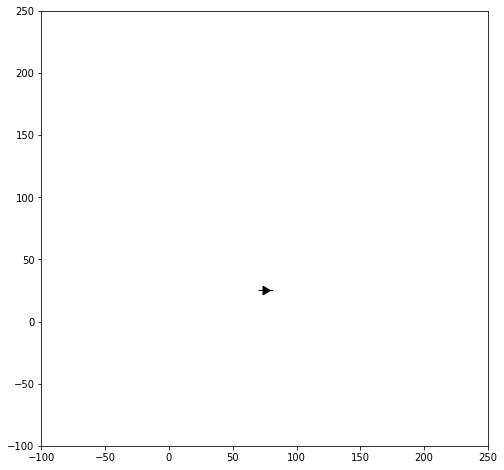

In [118]:
robot_params = {
    # pose
    "start_x": 0.75,
    "start_y": 0.25,
    "start_theta": 0,
    # physical dimensions
    "wheel_radius": 0.0325,
    "axle_length": 0.12,
    "camera_offset": 0.06, # camera is +6cm from center of wheel axle
    # stepwise motor control
    "motor_on_time": 0.1,  
    "motor_off_time": 0.2,
    # wheel velocity control
    "min_ang_velocity": 6.5, # Equivalent to motor speed setting of 0.3
    "focal_length": 0.00315 # camera focal lenght in meter
}

control_params = {
    "num_iter": 151,
    "interval": 5,
    "debug": False,
    "motion": True,
    "radius": 0.50,    # radius of circular trajectory
}

# Landmarks
landmarks = [
    {
    "label": 19,
    "obj_name": 'horse',
    "width": 0.394,
    "observed": False,
    "actual_x": 1.50,
    "actual_y": 1.50,
    "Mu": [],
    "blocked": [[1.3,1.56],[1.7,1.44]],    
    "barrier": np.array([[1.3,1.44],
                    [1.3,1.56],
                    [1.5,1.56],
                    [1.7,1.56],
                    [1.7,1.44],
                    [1.5,1.44]
                   ])
    },
    {
    "label": 44,
    "obj_name": 'bottle',
    "width": 0.10,
    "observed": False,
    "actual_x": 0.75,
    "actual_y": 1.75,
    "Mu": [],
    "blocked": [[0.7,1.55],[0.8,1.45]],    
    "barrier": np.array([[0.8,1.55],
                    [0.8,1.45],
                    [0.7,1.45],
                    [0.7,1.55]
                   ])
    },
    {
    "label": 63,
    "obj_name": 'couch',
    "width": 1.68,
    "observed": False,
    "actual_x": -0.50,
    "actual_y": 1.21,
    "Mu": [],
    "blocked": [[-1.45,2.18],[-0.25,0.5]],    
    "barrier": np.array([[-1.45,2.18],
                    [-0.25,2.18],
                    [-0.25,1.8],                         
                    [-0.25,1.4], 
                    [-0.25,1.0],
                    [-0.25,0.5],
                    [-1.45,0.5],
                    [-1.45,1.34]
                   ])
    },
    {
    "label": 72,
    "obj_name": 'TV',
    "width": 1.00,
    "observed": False,
    "actual_x": 2.0,
    "actual_y": 0.9,
    "Mu": [],
    "blocked": [[1.9,1.5],[2.5,0.25]],    
    "barrier": np.array([[1.9,1.5],
                    [2.5,1.5],
                    [2.5,0.9],
                    [2.5,0.25],
                    [1.9,0.25],
                    [1.9,0.9]
                   ])
    },
    {
    "label": 64,
    "obj_name": 'potted plant',
    "width": 0.55,
    "observed": False,
    "actual_x": 0.25,
    "actual_y": 0,
    "Mu": [],
    "blocked": [[0.2,0.1],[0.8,-0.3]],    
    "barrier": np.array([[0.2,0.1],
                    [0.8,0.1],
                    [0.8,-0.3],
                    [0.2,-0.3]
                   ])
    }
]

landmark_item_list = []
for item in landmarks:
    landmark_item_list.append(item['label'])
    
# Display camera image with bounding boxes for detected objects
display(widgets.HBox([image_widget]))
image = undistort(camera.value, mtx, dist) # undistort camera image
image_widget.value = bgr8_to_jpeg(image)  # update image widget with camera image

LARGE = 1e6
t_delta = 0.1  # motor on time
R_t = np.eye(3)*0.001  # Assume small constant control noise for now
Q_t = np.eye(2)*0.001  # Assume small constant  measurement noise for now

diag_dir = 'diagnostics'
np.set_printoptions(precision=5)

# Load camera parameters
focal_length = robot_params["focal_length"]
correct_factor = 0.769
camera_offset = robot_params["camera_offset"]

# Load robot parameters
wheel_radius = robot_params["wheel_radius"]
axle_length = robot_params["axle_length"]
T = control2robot(wheel_radius,axle_length)
x = robot_params["start_x"]
y = robot_params["start_y"]
theta = robot_params["start_theta"]

# load control parameters 
num_iter = control_params["num_iter"]
interval = control_params["interval"]
motion = control_params["motion"]
debug = control_params["debug"] 
radius = control_params["radius"] 

""" Initialize Mu and Sigma """
Mu, Sigma = initialize_Mu_Sigma(x,y,theta,landmark_item_list)
# Mu_prev = Mu
if debug:
    print(Mu)
    print(Sigma)

# Place robot (and landmark)on map
update_map(Mu, landmarks, debug=True)

In [119]:
# Display camera image with bounding boxes for detected objects
display(widgets.HBox([image_widget]))

""" Robot moves stepwise in a circle """
for i in range(num_iter):
    
    """ Move robot - Take 1 step in a left circular trajectory of radius 0.4m """
    wheel_velocities = take_circ_step(robot_params, 'L', radius, debug=debug, motion=motion)
    robot_velocities = np.dot(T,wheel_velocities)   # calculate (v,omega)
    if debug:
        print("Step: ", i+1)
        print("(w_r,w_l): {}".format(wheel_velocities))
        print("(v,omega): {}".format(robot_velocities))
        
    """ =================== """        
    """ EKF Prediction Step """
    """ =================== """
    
    v = robot_velocities[0,0]
    w = robot_velocities[1,0]
    theta = Mu[2,0]%(2*math.pi)  # robot orientation (normalize to 2*pi)
    N = Mu.shape[0]   # N=3+2n, n=num of landmarks
    
    # Calculate delta in robot's pose in the world frame
    x_delta, y_delta, theta_delta = robot_pose_delta(v,w,theta,t_delta)

    G_t = compute_G_t(v,w,theta,t_delta,N)  # Generate G_t 
    
    # Update Mu and Sigma based on change in robot pose
    Mu, Sigma = prediction_step_update(Mu, Sigma, x_delta, y_delta, theta_delta, G_t, R_t, N)
    
    if debug:
        print("(dx,dy,dtheta):{:.2f},{:.2f},{:.2f}".format(x_delta,y_delta,theta_delta))
        print("Mu:",Mu)
        # np.set_printoptions(suppress=True)
        print("G:",G_t)
        print("Sigma:",Sigma)
    
    """ Grab camera image, undistort and detect objects """
    image = undistort(camera.value, mtx, dist) # undistort camera image
    detections = model(image) # Use SSD model to detect objects
    
    """ Identify landmarks and estimate range(r)/bearing(phi) from robot """
    items = []
    for det in detections[0]:
        
        coco_id =det['label']
        if coco_id in landmark_item_list and valid_bbox(det["bbox"], width, height):
            """ If object detected is a landmark and its bounding box does not 
            borders the edges of the camera video """
            
            """ =================== """        
            """ EKF Correction Step """
            """ =================== """
            
            # Obtain landmark's left, center and right in horizontal pixel coordinate
            u_l, u_c, u_r = landmark_coordinates(det, width, height)
            j = landmark_item_list.index(coco_id)   # get landmark's index
            
            # Estimate landmark's range and bearing(r,phi) from robot
            r, phi = estimate_range_bearing(landmarks, j, \
                                            u_l, u_c, u_r, \
                                            c_u, focal_length, correct_factor, camera_offset)
            z_t = np.array([[r],[phi]])  # z_t - actual observation

            """ If landmark j encountered for 1st time, update (Mu_j_x, Mu_j_y) """
            if landmarks[j]['observed'] is False:
                # Update Mu's landmark coordinate
                landmarks[j]['observed'] = True
                Mu = update_landmark_Mu(Mu, j,  r, phi)

            # Get landmark j's expected observation
            delta, q, z_t_hat = get_observation(Mu, j)  # z_t_hat - expected observation
            
            # Compute H_t 
            H_t = compute_H_t(delta, j, q, N)  
            
            # Compute Kalmain Gain K_t
            K_t = compute_Kalman_Gain(delta, q, j, H_t, Sigma, N, Q_t)
            
            if debug:            
                print("Mu before Correction:", Mu)
                print("Kalman Gain", K_t)
                
            # Mu_prev = Mu
            # Mu = Mu_prev + np.dot(K_t, (z_t-z_t_hat))
            
            Mu = Mu + np.dot(K_t, (z_t-z_t_hat))
            Sigma = np.dot((np.eye(N)-np.dot(K_t,H_t)), Sigma)
            
            if True:
                print("Step: ", i+1)
                print("{} (left,center, right):{:.1f},{:.1f}, \
                {:.1f}".format(COCO_labels[coco_id-1], u_l, u_c, u_r))
                print("{} estimated phi:{:.1f} degree".format(COCO_labels[coco_id-1],phi/3.14*180))
                print("{} estimated range:{:.1f}cm".format(COCO_labels[coco_id-1],r*100)) 
                print("Mu after Correction:", Mu)
                print("robot: {:.1f},{:.1f}".format(Mu[0,0], Mu[1,0])) 
                print("{}: {:.1f},{:.1f}".format(COCO_labels[coco_id-1], Mu[3+2*j,0], Mu[3+2*j+1,0]))   
                print("delta:", delta)
                print("q: {:.2f}".format(q))
                print("observation:", z_t)
                print("expected observation:", z_t_hat)
                
            items.append(det)  # save item to display bounding box in image
    
    # Keep track of Mu of landmarks over time
    for j,landmark in enumerate(landmarks):
        x = np.asscalar(Mu[3+2*j,0])
        y = np.asscalar(Mu[3+2*j+1,0])                
        landmark["Mu"].append([x,y])
    
    # Update robot and landmark on map
    if i%interval==0:
        update_map(Mu, landmarks,folder=diag_dir,ind=i,debug=debug)
    
    cv2.line(image,(int(c_u),0),(int(c_u),300),GREEN,1)        
    draw_landmarks(image, items, width, height, debug) # put bounding boxes on detected objects
    image_widget.value = bgr8_to_jpeg(image)  # update image widget with camera image

Step:  1
tv (left,center, right):13.4,69.1,                 124.7
tv estimated phi:27.7 degree
tv estimated range:117.5cm
Mu after Correction: [[0.774  ]
 [0.25058]
 [0.04801]
 [0.     ]
 [0.     ]
 [0.     ]
 [0.     ]
 [0.     ]
 [0.     ]
 [1.78707]
 [0.84664]
 [0.     ]
 [0.     ]]
robot: 0.8,0.3
tv: 1.8,0.8
delta: [[1.01308]
 [0.59607]]
q: 1.38
observation: [[1.17542]
 [0.48381]]
expected observation: [[1.17542]
 [0.48381]]
Step:  2
tv (left,center, right):35.5,86.2,                 136.9
tv estimated phi:22.5 degree
tv estimated range:122.9cm
Mu after Correction: [[0.77022]
 [0.24958]
 [0.10981]
 [0.     ]
 [0.     ]
 [0.     ]
 [0.     ]
 [0.     ]
 [0.     ]
 [1.81706]
 [0.84551]
 [0.     ]
 [0.     ]]
robot: 0.8,0.2
tv: 1.8,0.8
delta: [[0.98914]
 [0.59434]]
q: 1.33
observation: [[1.22941]
 [0.39288]]
expected observation: [[1.15396]
 [0.44503]]
Step:  3
tv (left,center, right):48.2,96.0,                 143.8
tv estimated phi:19.3 degree
tv estimated range:127.3cm
Mu after Cor

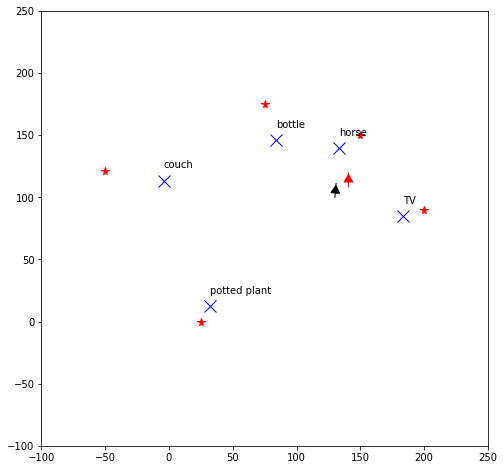

In [121]:
    """ Update robot position on map """
    plt.figure(figsize=(8,8))
    plt.xlim([-100,250])
    plt.ylim([-100,250])
    
    """ Display robot as line + triangle (arrow) """
    robot_x = Mu[0,0]*100
    robot_y = Mu[1,0]*100
    robot_theta = Mu[2,0]*180/math.pi - 90 # Adjust orientation to match matplotlib
    
    if debug:
        print("(x,y):{:.1f}, {:.1f}".format(robot_x,robot_y))
        print("Orientation: {:.1f}".format(normalize_angle(Mu[2,0])*180/math.pi))
    
    robot_x_actual = 140
    robot_y_actual = 115
    robot_theta_actual = (math.pi*1/2)*180/math.pi - 90 # Adjust orientation to match matplotlib    
    
    # robot = line + triangle
    plt.plot(robot_x, robot_y, marker=(2, 0, robot_theta), c='k',markersize=15, linestyle='None')
    plt.plot(robot_x, robot_y, marker=(3, 0, robot_theta), c='k',markersize=10, linestyle='None')

    # robot = line + triangle
    plt.plot(robot_x_actual, robot_y_actual, marker=(2, 0, robot_theta_actual), \
             c='r',markersize=15, linestyle='None')
    plt.plot(robot_x_actual, robot_y_actual, marker=(3, 0, robot_theta_actual), \
             c='r',markersize=10, linestyle='None')
    
    """ Display landmark as green cross, uncorrected landmark as lime cross """
    for i, landmark in enumerate(landmarks):
        if landmark['observed'] is True:
            # Mark landmark's actual locations
            landmark_x_actual = landmark["actual_x"]*100
            landmark_y_actual = landmark["actual_y"]*100
            plt.plot(landmark_x_actual, landmark_y_actual, marker='*', markersize=8, color='red') 
            # Mark landmark (post-Kalman correction)
            landmark_x = Mu[3+2*i]*100
            landmark_y = Mu[3+2*i+1]*100
            plt.plot(landmark_x, landmark_y,marker='x', markersize=12, color='blue')
            plt.text(landmark_x, landmark_y+10, landmark["obj_name"])
    
    plt.savefig('diagnostics/map_final.png')
    plt.show()
    plt.close()




## Implement Pursuit

In [122]:
robot_params = {
    # pose
    "start_x": 1.0,
    "start_y": 0.3,
    "start_theta": 0,
    # physical dimensions
    "wheel_radius": 0.0325,
    "axle_length": 0.12,
    "camera_offset": 0.06, # camera is +6cm from center of wheel axle
    "focal_length": 0.00315, # camera focal lenght in meter
    # stepwise motor control
    "motor_on_time": 0.1,  
    "motor_off_time": 0.2,
    # wheel velocity control
    "min_ang_velocity": 6.5, # Equivalent to motor speed setting of 0.3
}

control_params = {
    "num_iter": 301,
    "interval": 10,
    "debug": True,
    "motion": False,
    "speed_lower": 0.14,  # This ensures motor settings > ~0.3
    "speed_upper": 5.0  # This ensures motor settings > ~0.5
}

pursuit_params = {
    "K_v": 0.5,
    "K_i": 0,
    "K_h": 0.5,
    "lag": 0.02
}

trajec_params = {
    "points": [],   # used for storing evenly spaced points in trajectory
    "current": 0,   # point to the current pursuit point
}


In [123]:
def generate_points(start, end, interval, debug=False):
    """ Generate a sequence of equally distance points for a path """
    start_x, start_y = start
    end_x, end_y = end
    theta = math.atan2((end_y-start_y),(end_x-start_x))
       
    if debug:
        print("From {} to {}".format(np.around(np.array(start),3), np.around(np.array(end),3)))
        print("theta: {:.1f}".format(theta))
    
    points = []
    current_pt = start
    next_pt = start
    
    # Generate a sequence of points from start to end
    while distance(start,next_pt) < distance(start,end):
        points.append(current_pt)
        next_pt = (current_pt[0] + interval*math.cos(theta), current_pt[1]+interval*math.sin(theta))
        current_pt = next_pt
        
    return points

def generate_trajectory(path, vor, interval, debug=False):
    """ Convert path into points for robot to follow """
    
    points = []
    # for each path segment
    for i in range(len(path)-1):
        # generate points for the segment
        start = [vor.vertices[int(path[i]), 0],vor.vertices[int(path[i]), 1]]
        end = [vor.vertices[int(path[i+1]), 0],vor.vertices[int(path[i+1]), 1]]
        if debug:
            print(path[i], path[i+1])
        points.extend(generate_points(start,end,interval)) 
        
    return points

def closest_point(traj, robot_pose):
    """ Pick the next point in the trajectory to pursue """
    robot_x = robot_pose[0]
    robot_y = robot_pose[1]
    robot_theta = robot_pose[2]
    
    current = traj["current"]
    points = traj["points"][current:]
    
    nearest = None
    # Go through all pts in trajectory and pick the pt nearest to robot
    for i, pt in enumerate(points):
        if nearest is None:
            nearest = pt
        else:
            if distance(pt,[robot_x,robot_y])<distance(nearest,[robot_x,robot_y]):
                nearest = pt
                current = traj["current"]+i
                
    return current, nearest

def last_pt(trajec_params):
    """ Return true if current pt is the last pt of the trajectory """
    if trajec_params["current"] == len(trajec_params["points"]):
        # Return None if already at the last pt of trajectory
        return True
    else:
        return False
    

def next_pursuit_pt(robot_pose, pursuit_pt, trajec_params):
    """ Provide next pursuit point to robot if available or if necessary """
    
    if last_pt(trajec_params):
        # Return None if already at the last pt of trajectory
        return None
    else:
        # Look for suitable next pursuit pt in trajectory
        while distance(robot_pos,pursuit_pt)<0.10:
            trajec_params["current"] += 1  # set next pt in trajectory as pursuit pt
            if last_pt(trajec_params):
                # Return None if reaches the last pt of trajectory
                return None
            pursuit_pt = trajec_params["points"][trajec_params["current"]]
            
    return pursuit_pt


def animate_robot(robot_pose, landmarks, vor, display_param, path=None, pursuit_pt=None):
    """ Update map to display landmarks, robot, trajectory and pursuit point """
    
    # Load display parameters
    plt.figure(figsize=display_param["figsize"]) 
    plt.xlim(display_param["xlim"]); plt.ylim(display_param["ylim"])
    
    # Plot landmarks and voronoi vertices
    plt.plot(landmarks[:, 0], landmarks[:, 1], 'o')
    plt.plot(vor.vertices[:, 0], vor.vertices[:, 1], '*')
    
    # Plot trajectory
    if path is not None:
        path = np.array(path)
        plt.plot(path[:,0],path[:,1], 'x')
    
    # Plot robot pose (robot = line + triangle)
    robot_x_actual = robot_pose[0]
    robot_y_actual = robot_pose[1]
    robot_theta_actual = robot_pose[2]*180/math.pi - 90 # Adjust orientation to match matplotlib    
    
    plt.plot(robot_x_actual, robot_y_actual, marker=(2, 0, robot_theta_actual), \
             c='r',markersize=15, linestyle='None')
    plt.plot(robot_x_actual, robot_y_actual, marker=(3, 0, robot_theta_actual), \
             c='r',markersize=10, linestyle='None')

    # Plot pursuit pt
    if pursuit_pt is not None:
        plt.plot(pursuit_pt[0],pursuit_pt[1], 'x', c='r')

    plt.show()
    plt.close()
    
    return

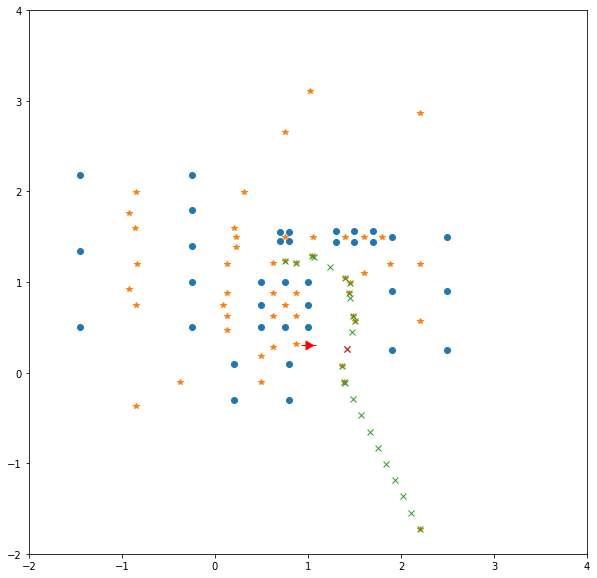

In [124]:
robot_pose = [robot_params["start_x"],robot_params["start_y"],robot_params["start_theta"]]

# Initialize trajec_params
trajec_params["points"] = generate_trajectory(shortest, vor, 0.20, debug=False)
trajec_params["current"] = 0

# pursuit point is set at the pt in trajectory closest to the robot
trajec_params["current"], pursuit_pt = closest_point(trajec_params,robot_pose)

display_param = {
    "figsize": (10,10),
    "xlim": [-2,4],
    "ylim": [-2,4]
    }

# Update map
animate_robot(robot_pose, points, vor, display_param, path=trajec_params["points"], pursuit_pt=pursuit_pt)

1 26
26 27
27 11
11 10
10 14
14 21
21 35
35 36
36 23
23 22
22 19
[[ 0.20618]
 [-0.28364]]


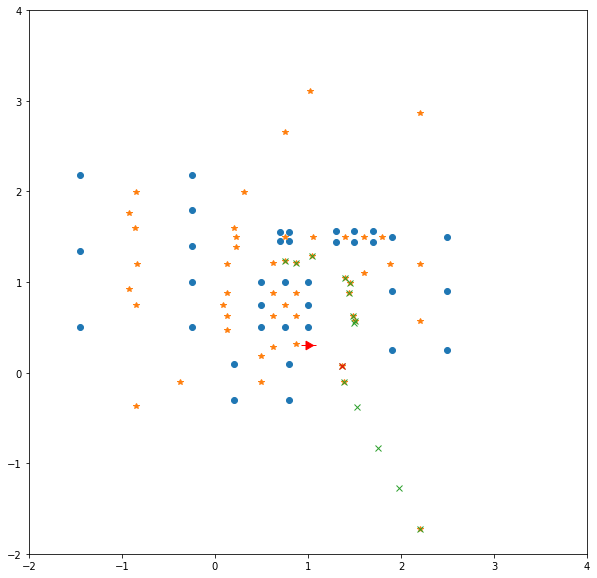

Step:  1
theta:-0.5672700503534143
e:0.4123531926154619 e_theta:-0.5672700503534145
(v,omega): [[ 0.20618]
 [-0.28364]]
(x,y,theta) before: 1.0, 0.3, 0
Clamped wheel Velocities: [[5.82026]
 [6.86753]] (0.3560879026699086, 0.3366219587058224)
(x,y,theta) after: 1.0206148952977305, 0.2997076250813816, -0.028363502517670627
[[ 0.19748]
 [-0.28251]]
[[ 0.18913]
 [-0.28136]]
[[ 0.18113]
 [-0.28019]]
[[ 0.17345]
 [-0.27901]]
[[ 0.16609]
 [-0.27781]]
[[ 0.15902]
 [-0.27658]]
[[ 0.15225]
 [-0.27534]]
[[ 0.14576]
 [-0.27407]]
[[ 0.13954]
 [-0.27278]]
Robot speed boosted [[ 0.14   ]
 [-0.27278]]
[[ 0.13355]
 [-0.27151]]
Robot speed boosted [[ 0.14   ]
 [-0.27151]]


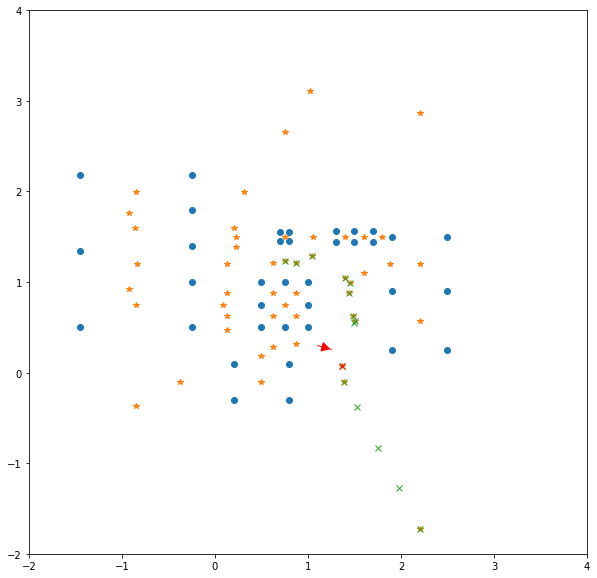

Step:  11
theta:-0.8213505463241854
e:0.2670937144352353 e_theta:-0.5430217217882252
(v,omega): [[ 0.14   ]
 [-0.27151]]
(x,y,theta) before: 1.1690563940415104, 0.27785462728753346, -0.2783288245359603
Clamped wheel Velocities: [[3.80644]
 [4.80894]] (0.31782422170640395, 0.29943430503350804)
(x,y,theta) after: 1.1824637483352278, 0.27382587928004604, -0.3054799106253715
[[ 0.12755]
 [-0.27079]]
Robot speed boosted [[ 0.14   ]
 [-0.27079]]
[[ 0.12155]
 [-0.27065]]
Robot speed boosted [[ 0.14   ]
 [-0.27065]]
[[ 0.11555]
 [-0.27116]]
Robot speed boosted [[ 0.14   ]
 [-0.27116]]
[[ 0.10956]
 [-0.27237]]
Robot speed boosted [[ 0.14   ]
 [-0.27237]]
[[ 0.10358]
 [-0.27436]]
Robot speed boosted [[ 0.14   ]
 [-0.27436]]
[[ 0.09762]
 [-0.27723]]
Robot speed boosted [[ 0.14   ]
 [-0.27723]]
[[ 0.09168]
 [-0.28109]]
Robot speed boosted [[ 0.14   ]
 [-0.28109]]
[[ 0.08578]
 [-0.28608]]
Robot speed boosted [[ 0.14   ]
 [-0.28608]]
[[ 0.07991]
 [-0.29239]]
Robot speed boosted [[ 0.14   ]
 [-0.2923

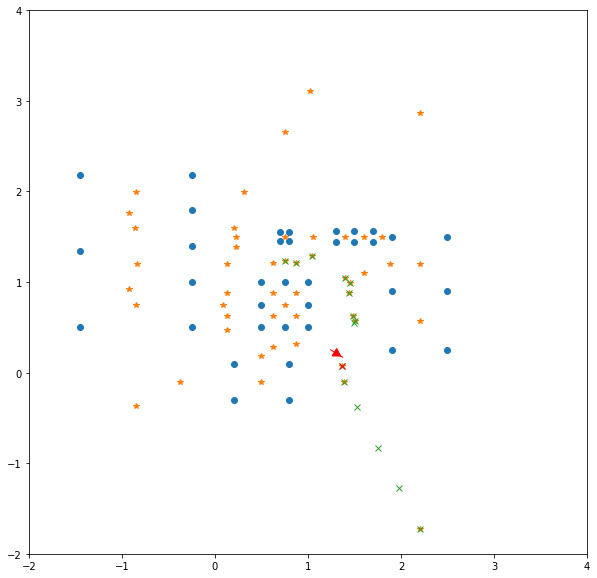

Step:  21
theta:-1.155559643620555
e:0.14821444201372183 e_theta:-0.6004677450607638
(v,omega): [[ 0.14   ]
 [-0.30023]]
(x,y,theta) before: 1.2967753450667558, 0.2216026513337891, -0.5550918985597912
Clamped wheel Velocities: [[3.75341]
 [4.86197]] (0.31880985550576124, 0.2987456414178532)
(x,y,theta) after: 1.308560733379456, 0.21404686548235047, -0.5851152858128295
[[ 0.06837]
 [-0.30991]]
Robot speed boosted [[ 0.14   ]
 [-0.30991]]
[[ 0.06272]
 [-0.32178]]
Robot speed boosted [[ 0.14   ]
 [-0.32178]]
[[ 0.05718]
 [-0.33629]]
Robot speed boosted [[ 0.14   ]
 [-0.33629]]
[[ 0.05178]
 [-0.35405]]
Robot speed boosted [[ 0.14   ]
 [-0.35405]]
[[ 0.04656]
 [-0.3758 ]]
Robot speed boosted [[ 0.14  ]
 [-0.3758]]
[[ 0.04157]
 [-0.40247]]
Robot speed boosted [[ 0.14   ]
 [-0.40247]]
[[0.19402]
 [1.02736]]
[[0.19827]
 [0.99713]]
[[0.20208]
 [0.96903]]
[[0.20546]
 [0.94284]]


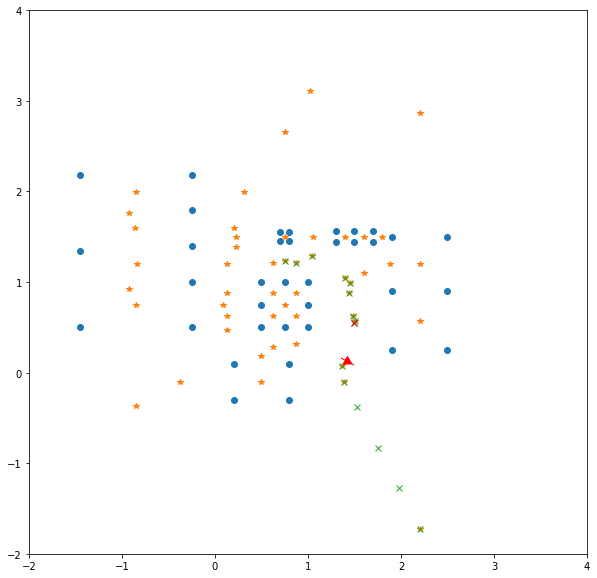

Step:  31
theta:1.3898939796206546
e:0.4109255926741457 e_theta:1.8856875587761
(v,omega): [[0.20546]
 [0.94284]]
(x,y,theta) before: 1.4209251224601926, 0.12554824248662583, -0.49579357915544553
Clamped wheel Velocities: [[8.06257]
 [4.5813 ]] (0.3135928908057146, 0.3783004993424983)
(x,y,theta) after: 1.439431139652198, 0.11663957812705207, -0.40150920121664035
[[0.2084 ]
 [0.91838]]
[[0.21091]
 [0.89548]]
[[0.21299]
 [0.87399]]
[[0.21466]
 [0.85378]]
[[0.21592]
 [0.83474]]
[[0.21679]
 [0.81677]]
[[0.21728]
 [0.79977]]
[[0.21742]
 [0.78367]]
[[0.21722]
 [0.76839]]
[[0.21669]
 [0.75387]]


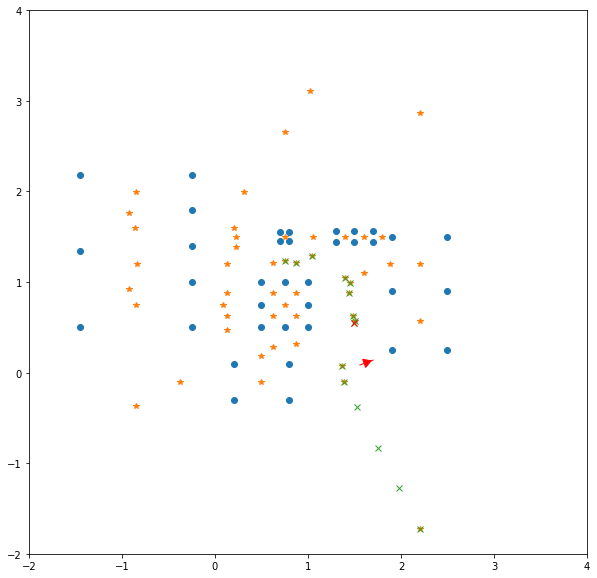

Step:  41
theta:1.8607248404410628
e:0.43338318887117394 e_theta:1.507736091082629
(v,omega): [[0.21669]
 [0.75387]]
(x,y,theta) before: 1.6280709522207344, 0.11498095084317121, 0.3529887493584341
Clamped wheel Velocities: [[8.05919]
 [5.27568]] (0.326499577754138, 0.37823773358196644)
(x,y,theta) after: 1.6481025853815376, 0.12323103006316646, 0.42837555391256577
[[0.21586]
 [0.74004]]
[[0.21474]
 [0.72686]]
[[0.21335]
 [0.71427]]
[[0.21171]
 [0.70224]]
[[0.20984]
 [0.69072]]
[[0.20775]
 [0.67968]]
[[0.20546]
 [0.66908]]
[[0.20299]
 [0.6589 ]]
[[0.20036]
 [0.64911]]
[[0.19757]
 [0.63967]]


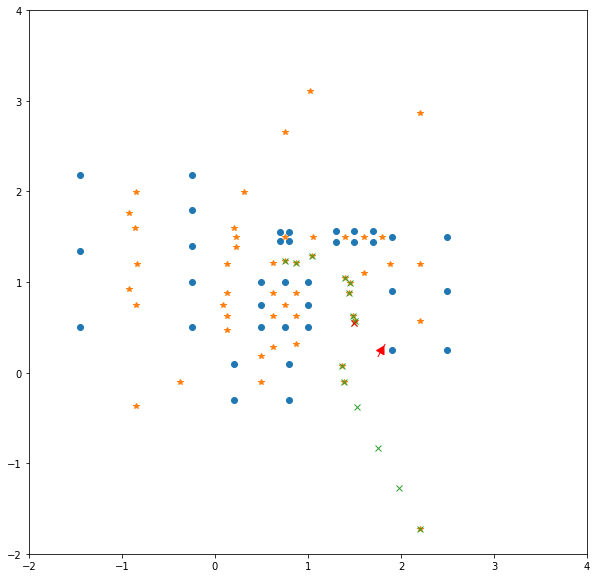

Step:  51
theta:2.330809664048902
e:0.3951359530357551 e_theta:1.2793430846651237
(v,omega): [[0.19757]
 [0.63967]]
(x,y,theta) before: 1.7844561521447386, 0.24854020795954682, 1.051466579383778
Clamped wheel Velocities: [[7.25995]
 [4.89808]] (0.31948108892074684, 0.3633819096699076)
(x,y,theta) after: 1.7937063408821632, 0.2659939176983825, 1.1154337336170344
[[0.19464]
 [0.63058]]
[[0.1916]
 [0.6218]]
[[0.18844]
 [0.61332]]
[[0.18519]
 [0.60512]]
[[0.18185]
 [0.59718]]
[[0.17844]
 [0.58948]]
[[0.17498]
 [0.58202]]
[[0.17146]
 [0.57478]]
[[0.1679 ]
 [0.56774]]
[[0.1643 ]
 [0.56089]]


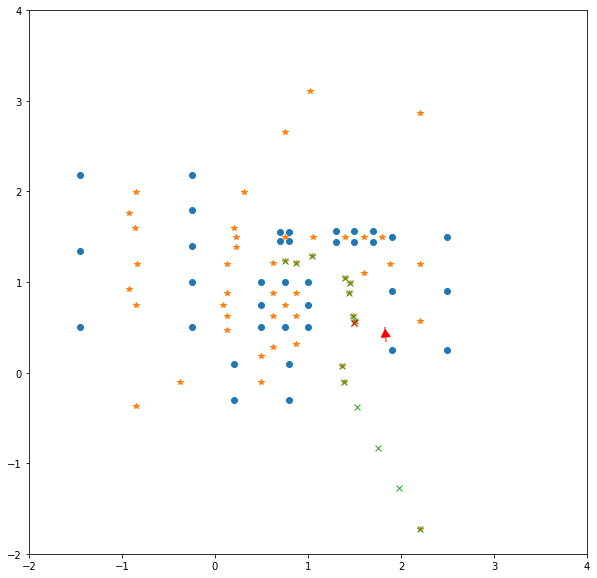

Step:  61
theta:2.7754196370652484
e:0.32860517300105063 e_theta:1.1217859562546062
(v,omega): [[0.1643 ]
 [0.56089]]
(x,y,theta) before: 1.823950266025002, 0.42462561524558035, 1.6536336808106422
Clamped wheel Velocities: [[6.09096]
 [4.01997]] (0.3031592838506656, 0.34165351168897073)
(x,y,theta) after: 1.8221324152133234, 0.44095283338471, 1.7097229786233727
[[0.16069]
 [0.55423]]
[[0.15706]
 [0.54774]]
[[0.15342]
 [0.54141]]
[[0.14978]
 [0.53523]]
[[0.14615]
 [0.5292 ]]
[[0.14253]
 [0.5233 ]]
[[0.13892]
 [0.51754]]
Robot speed boosted [[0.14   ]
 [0.51754]]
[[0.13532]
 [0.51205]]
Robot speed boosted [[0.14   ]
 [0.51205]]
[[0.13165]
 [0.50722]]
Robot speed boosted [[0.14   ]
 [0.50722]]
[[0.12793]
 [0.50307]]
Robot speed boosted [[0.14   ]
 [0.50307]]


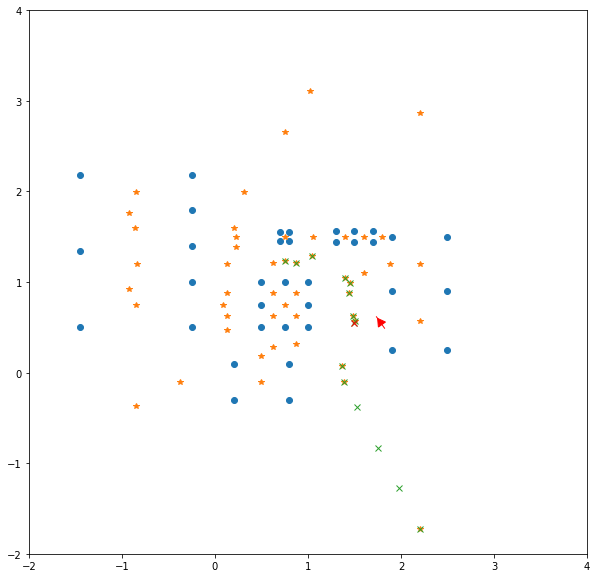

Step:  71
theta:-3.0905384861531906
e:0.25585513021325335 e_theta:1.0061316420843944
(v,omega): [[0.14   ]
 [0.50307]]
(x,y,theta) before: 1.7739517744686684, 0.5635193182513658, 2.1865151789420008
Clamped wheel Velocities: [[5.23643]
 [3.37896]] (0.2938825377572303, 0.32577005962970124)
(x,y,theta) after: 1.7655821305049573, 0.5747401795279456, 2.2368217610462207
[[0.12416]
 [0.4996 ]]
Robot speed boosted [[0.14  ]
 [0.4996]]
[[0.12036]
 [0.49683]]
Robot speed boosted [[0.14   ]
 [0.49683]]
[[0.11653]
 [0.4948 ]]
Robot speed boosted [[0.14  ]
 [0.4948]]
[[0.11267]
 [0.49352]]
Robot speed boosted [[0.14   ]
 [0.49352]]
[[0.10881]
 [0.49302]]
Robot speed boosted [[0.14   ]
 [0.49302]]
[[0.10495]
 [0.49334]]
Robot speed boosted [[0.14   ]
 [0.49334]]
[[0.10109]
 [0.49453]]
Robot speed boosted [[0.14   ]
 [0.49453]]
[[0.09726]
 [0.49662]]
Robot speed boosted [[0.14   ]
 [0.49662]]
[[0.09345]
 [0.49968]]
Robot speed boosted [[0.14   ]
 [0.49968]]
[[0.08969]
 [0.50376]]
Robot speed boosted 

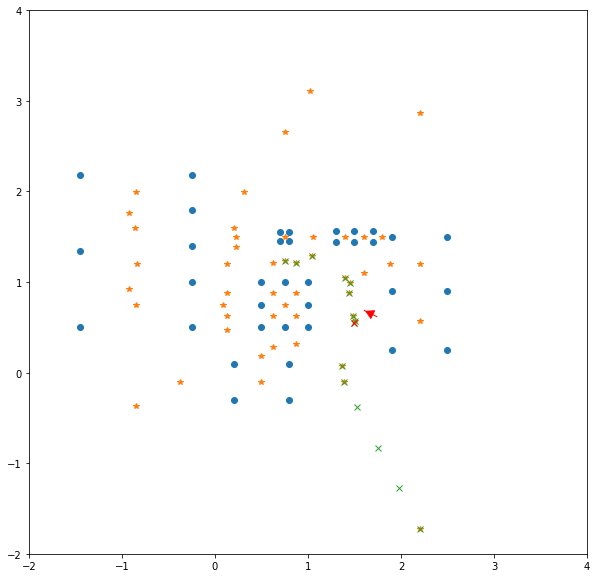

Step:  81
theta:-2.5926539085584737
e:0.17938365119245578 e_theta:1.0075155087253957
(v,omega): [[0.14   ]
 [0.50376]]
(x,y,theta) before: 1.6685460334247253, 0.6534767195891581, 2.683015889895717
Clamped wheel Velocities: [[5.23771]
 [3.37768]] (0.29386594794734816, 0.3257938034096441)
(x,y,theta) after: 1.6558417075256306, 0.6593553807929867, 2.7333916653319865
[[0.08598]
 [0.50892]]
Robot speed boosted [[0.14   ]
 [0.50892]]
[[0.08234]
 [0.51523]]
Robot speed boosted [[0.14   ]
 [0.51523]]
[[0.07879]
 [0.52276]]
Robot speed boosted [[0.14   ]
 [0.52276]]
[[0.07533]
 [0.53158]]
Robot speed boosted [[0.14   ]
 [0.53158]]
[[0.07199]
 [0.54177]]
Robot speed boosted [[0.14   ]
 [0.54177]]
[[0.06878]
 [0.5534 ]]
Robot speed boosted [[0.14  ]
 [0.5534]]
[[0.06573]
 [0.56651]]
Robot speed boosted [[0.14   ]
 [0.56651]]
[[0.06285]
 [0.58115]]
Robot speed boosted [[0.14   ]
 [0.58115]]
[[0.06017]
 [0.59733]]
Robot speed boosted [[0.14   ]
 [0.59733]]
[[0.05771]
 [0.61502]]
Robot speed boosted

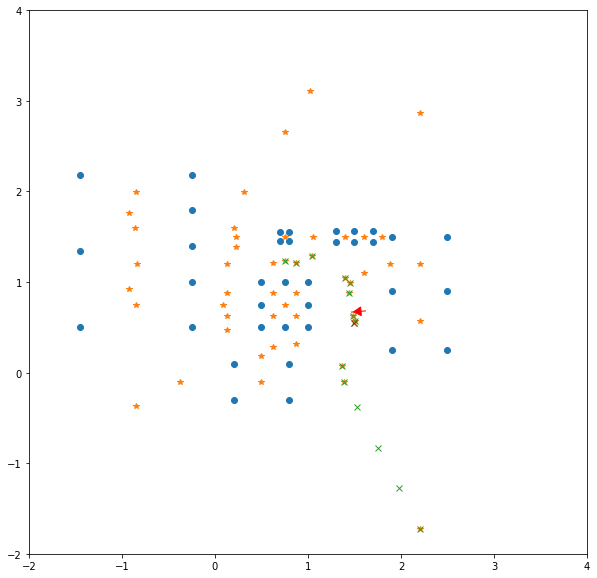

Step:  91
theta:-1.82789327018981
e:0.115424429847876 e_theta:1.2300352475352696
(v,omega): [[0.14   ]
 [0.61502]]
(x,y,theta) before: 1.5328909880467358, 0.6804152116998122, 3.2252567894545066
Clamped wheel Velocities: [[5.44311]
 [3.17228]] (0.2911983786509261, 0.3296116999863076)
(x,y,theta) after: 1.5189847156070615, 0.6788171458902287, 3.2867585518312703
[[0.0555 ]
 [0.63413]]
Robot speed boosted [[0.14   ]
 [0.63413]]
[[0.05355]
 [0.65454]]
Robot speed boosted [[0.14   ]
 [0.65454]]
[[0.05188]
 [0.67604]]
Robot speed boosted [[0.14   ]
 [0.67604]]
[[0.05051]
 [0.69835]]
Robot speed boosted [[0.14   ]
 [0.69835]]
[[0.04945]
 [0.72114]]
Robot speed boosted [[0.14   ]
 [0.72114]]
[[0.04871]
 [0.74401]]
Robot speed boosted [[0.14   ]
 [0.74401]]
[[0.04829]
 [0.76655]]
Robot speed boosted [[0.14   ]
 [0.76655]]
[[0.04818]
 [0.78834]]
Robot speed boosted [[0.14   ]
 [0.78834]]
[[0.04837]
 [0.80898]]
Robot speed boosted [[0.14   ]
 [0.80898]]
[[0.04883]
 [0.82815]]
Robot speed boosted [

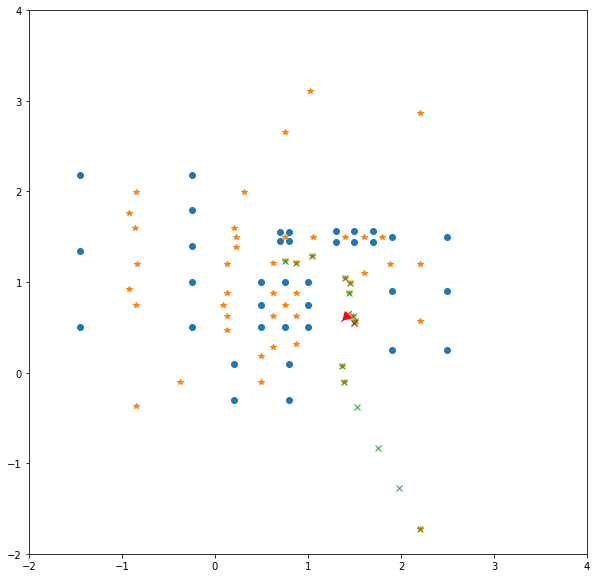

Step:  101
theta:-0.6909268629064526
e:0.09766295903549216 e_theta:1.6562914608881298
(v,omega): [[0.14   ]
 [0.82815]]
(x,y,theta) before: 1.4077784480455366, 0.6244228079675349, 3.9359669833850037
Clamped wheel Velocities: [[5.83658]
 [2.77881]] (0.28608841405528745, 0.33692521808787235)
(x,y,theta) after: 1.398392757686793, 0.6140402830359825, 4.018781556429411
[[0.04955]
 [0.84557]]
Robot speed boosted [[0.14   ]
 [0.84557]]
[[0.0505 ]
 [0.86108]]
Robot speed boosted [[0.14   ]
 [0.86108]]
[[0.05165]
 [0.87457]]
Robot speed boosted [[0.14   ]
 [0.87457]]
[[0.05297]
 [0.88601]]
Robot speed boosted [[0.14   ]
 [0.88601]]
[[0.05444]
 [0.89544]]
Robot speed boosted [[0.14   ]
 [0.89544]]
[[0.05602]
 [0.90295]]
Robot speed boosted [[0.14   ]
 [0.90295]]
[[0.05769]
 [0.90865]]
Robot speed boosted [[0.14   ]
 [0.90865]]
[[0.05943]
 [0.91268]]
Robot speed boosted [[0.14   ]
 [0.91268]]
[[0.06121]
 [0.91518]]
Robot speed boosted [[0.14   ]
 [0.91518]]
[[0.06301]
 [0.91632]]
Robot speed boos

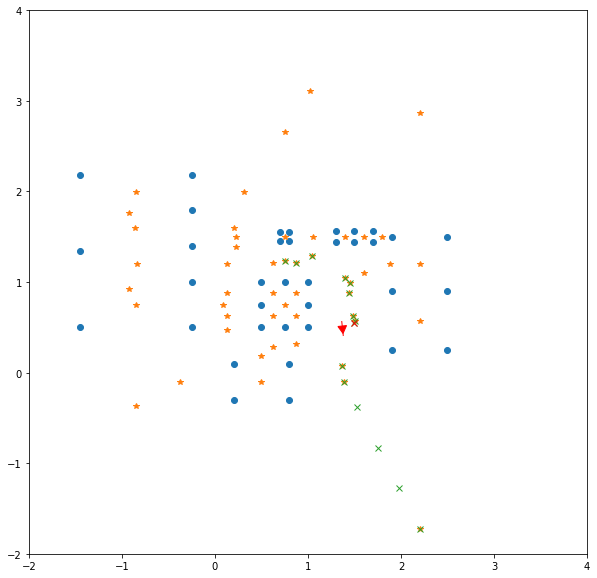

Step:  111
theta:0.36844818035460675
e:0.1260290086863031 e_theta:1.8326393421409195
(v,omega): [[0.14   ]
 [0.91632]]
(x,y,theta) before: 1.362227458227441, 0.4968468774245052, 4.818994145393273
Clamped wheel Velocities: [[5.99936]
 [2.61603]] (0.2839743535407685, 0.3399509180807712)
(x,y,theta) after: 1.3643523578010064, 0.483014028885769, 4.91062611250032
[[0.06483]
 [0.91624]]
Robot speed boosted [[0.14   ]
 [0.91624]]
[[0.06663]
 [0.91508]]
Robot speed boosted [[0.14   ]
 [0.91508]]
[[0.06841]
 [0.91299]]
Robot speed boosted [[0.14   ]
 [0.91299]]
[[0.07016]
 [0.91008]]
Robot speed boosted [[0.14   ]
 [0.91008]]
[[0.07187]
 [0.90648]]
Robot speed boosted [[0.14   ]
 [0.90648]]
[[0.07352]
 [0.90229]]
Robot speed boosted [[0.14   ]
 [0.90229]]
[[0.07511]
 [0.8976 ]]
Robot speed boosted [[0.14  ]
 [0.8976]]
[[0.07663]
 [0.8925 ]]
Robot speed boosted [[0.14  ]
 [0.8925]]
[[0.07808]
 [0.88707]]
Robot speed boosted [[0.14   ]
 [0.88707]]
[[0.07946]
 [0.88137]]
Robot speed boosted [[0.14

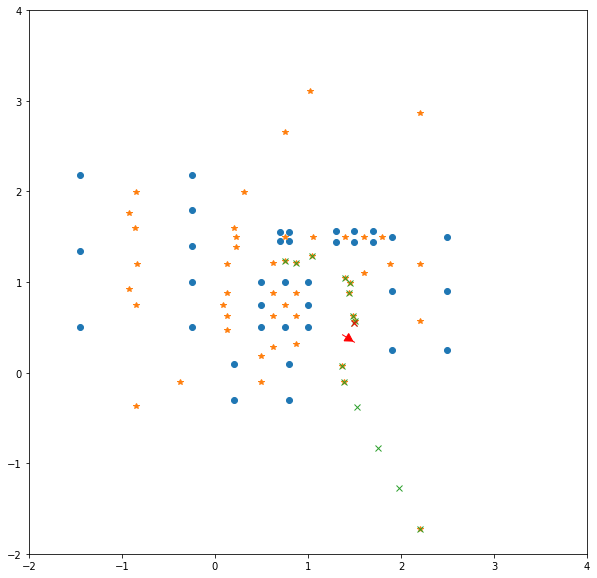

Step:  121
theta:1.2042170052086927
e:0.15891499971375841 e_theta:1.7627427489997647
(v,omega): [[0.14   ]
 [0.88137]]
(x,y,theta) before: 1.434328625024704, 0.3824141987069536, 5.7246595633885144
Clamped wheel Velocities: [[5.93484]
 [2.68055]] (0.2848122747372659, 0.33875166283671365)
(x,y,theta) after: 1.4465125198913589, 0.37552755519484554, 5.812796700838502
[[0.08075]
 [0.87547]]
Robot speed boosted [[0.14   ]
 [0.87547]]
[[0.08197]
 [0.86943]]
Robot speed boosted [[0.14   ]
 [0.86943]]
[[0.08309]
 [0.86328]]
Robot speed boosted [[0.14   ]
 [0.86328]]
[[0.08414]
 [0.85709]]
Robot speed boosted [[0.14   ]
 [0.85709]]
[[0.0851 ]
 [0.85087]]
Robot speed boosted [[0.14   ]
 [0.85087]]
[[0.08597]
 [0.84468]]
Robot speed boosted [[0.14   ]
 [0.84468]]
[[0.08675]
 [0.83853]]
Robot speed boosted [[0.14   ]
 [0.83853]]
[[0.08745]
 [0.83247]]
Robot speed boosted [[0.14   ]
 [0.83247]]
[[0.08807]
 [0.8265 ]]
Robot speed boosted [[0.14  ]
 [0.8265]]
[[0.0886 ]
 [0.82066]]
Robot speed boosted

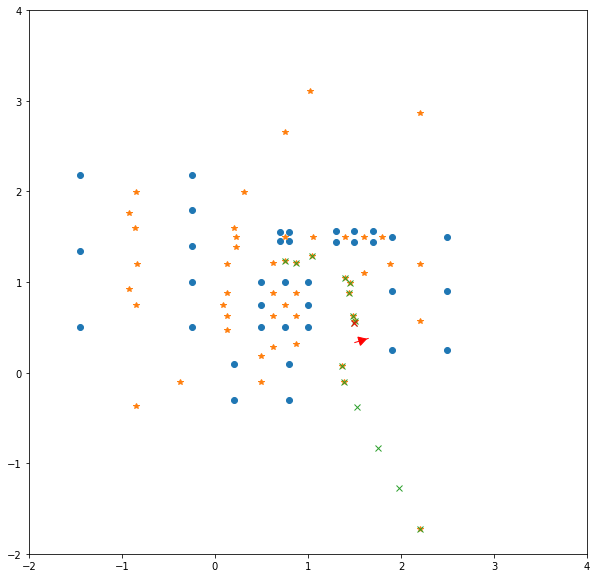

Step:  131
theta:1.9367725182059712
e:0.17720807672414862 e_theta:1.6413286996671532
(v,omega): [[0.14   ]
 [0.82066]]
(x,y,theta) before: 1.569029159326636, 0.3652939363654439, 6.578629125718404
Clamped wheel Velocities: [[5.82276]
 [2.79262]] (0.2862677878161783, 0.3366684935602033)
(x,y,theta) after: 1.5822403827139608, 0.36991493170627926, 6.660695560701762
[[0.08906]
 [0.81497]]
Robot speed boosted [[0.14   ]
 [0.81497]]
[[0.08943]
 [0.80943]]
Robot speed boosted [[0.14   ]
 [0.80943]]
[[0.08973]
 [0.80407]]
Robot speed boosted [[0.14   ]
 [0.80407]]
[[0.08996]
 [0.7989 ]]
Robot speed boosted [[0.14  ]
 [0.7989]]
[[0.09011]
 [0.79394]]
Robot speed boosted [[0.14   ]
 [0.79394]]
[[0.0902 ]
 [0.78918]]
Robot speed boosted [[0.14   ]
 [0.78918]]
[[0.09022]
 [0.78465]]
Robot speed boosted [[0.14   ]
 [0.78465]]
[[0.09018]
 [0.78034]]
Robot speed boosted [[0.14   ]
 [0.78034]]
[[0.09008]
 [0.77627]]
Robot speed boosted [[0.14   ]
 [0.77627]]
[[0.08992]
 [0.77245]]
Robot speed boosted [

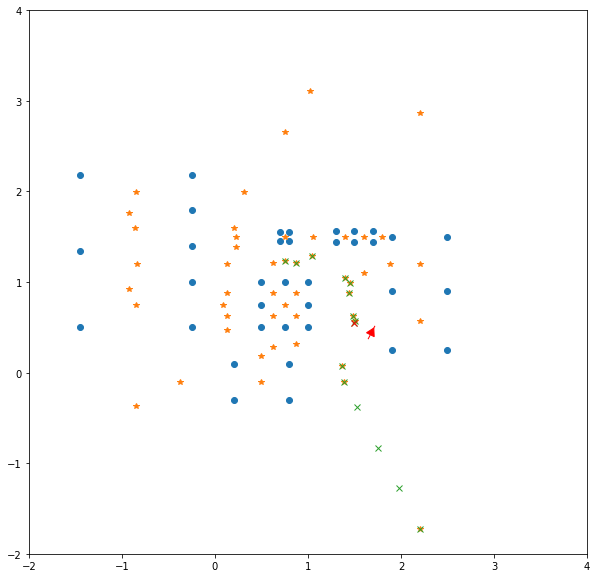

Step:  141
theta:2.637586893529733
e:0.17984908777734213 e_theta:1.544900776024864
(v,omega): [[0.14   ]
 [0.77245]]
(x,y,theta) before: 1.6734549436760922, 0.4529273491654713, 7.375871424684455
Clamped wheel Velocities: [[5.73375]
 [2.88163]] (0.28742376692078114, 0.335014025324991)
(x,y,theta) after: 1.679410125402659, 0.4655937761406231, 7.453116463485698
[[0.08972]
 [0.76887]]
Robot speed boosted [[0.14   ]
 [0.76887]]
[[0.08946]
 [0.76555]]
Robot speed boosted [[0.14   ]
 [0.76555]]
[[0.08916]
 [0.76248]]
Robot speed boosted [[0.14   ]
 [0.76248]]
[[0.08882]
 [0.75967]]
Robot speed boosted [[0.14   ]
 [0.75967]]
[[0.08845]
 [0.75712]]
Robot speed boosted [[0.14   ]
 [0.75712]]
[[0.08803]
 [0.75483]]
Robot speed boosted [[0.14   ]
 [0.75483]]
[[0.08759]
 [0.75279]]
Robot speed boosted [[0.14   ]
 [0.75279]]
[[0.08712]
 [0.75102]]
Robot speed boosted [[0.14   ]
 [0.75102]]
[[0.08663]
 [0.74951]]
Robot speed boosted [[0.14   ]
 [0.74951]]
[[0.08612]
 [0.74825]]
Robot speed boosted [[

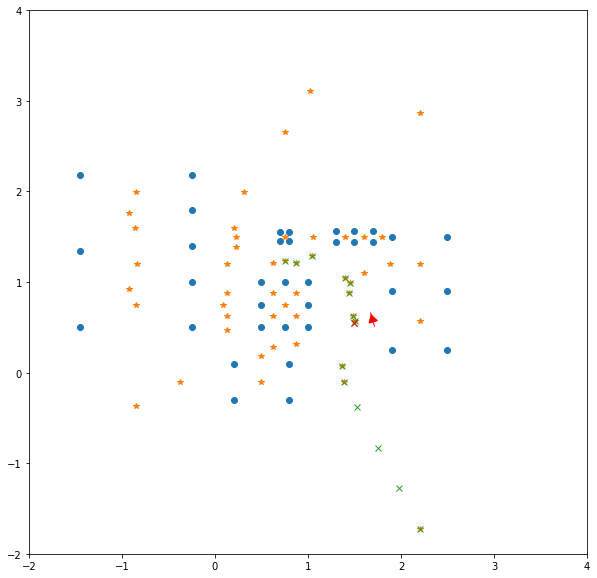

Step:  151
theta:-2.9345614850710584
e:0.1722405295561425 e_theta:1.4965083593422221
(v,omega): [[0.14   ]
 [0.74825]]
(x,y,theta) before: 1.6865914047048363, 0.5889579560688333, 8.135300769945891
Clamped wheel Velocities: [[5.68908]
 [2.9263 ]] (0.2880038957921015, 0.33418372935674434)
(x,y,theta) after: 1.6822053526483607, 0.602249724824385, 8.210126187913001
[[0.08559]
 [0.74725]]
Robot speed boosted [[0.14   ]
 [0.74725]]
[[0.08505]
 [0.7465 ]]
Robot speed boosted [[0.14  ]
 [0.7465]]
[[0.08451]
 [0.74598]]
Robot speed boosted [[0.14   ]
 [0.74598]]
[[0.08395]
 [0.74571]]
Robot speed boosted [[0.14   ]
 [0.74571]]
[[0.0834 ]
 [0.74567]]
Robot speed boosted [[0.14   ]
 [0.74567]]
[[0.08284]
 [0.74586]]
Robot speed boosted [[0.14   ]
 [0.74586]]
[[0.08229]
 [0.74626]]
Robot speed boosted [[0.14   ]
 [0.74626]]
[[0.08175]
 [0.74686]]
Robot speed boosted [[0.14   ]
 [0.74686]]
[[0.08122]
 [0.74767]]
Robot speed boosted [[0.14   ]
 [0.74767]]
[[0.08069]
 [0.74866]]
Robot speed boosted [

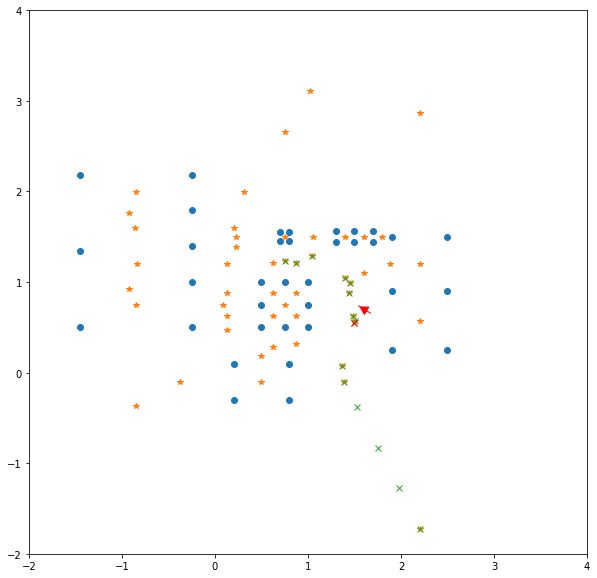

Step:  161
theta:-2.1871480836960044
e:0.1613890075003489 e_theta:1.4973201719165914
(v,omega): [[0.14   ]
 [0.74866]]
(x,y,theta) before: 1.6033101841055124, 0.6974540045394745, 8.881902358746576
Clamped wheel Velocities: [[5.68983]
 [2.92555]] (0.28799416377322795, 0.33419765808264146)
(x,y,theta) after: 1.5910636010263786, 0.7042311479623073, 8.956768367342406
[[0.08019]
 [0.74983]]
Robot speed boosted [[0.14   ]
 [0.74983]]
[[0.0797 ]
 [0.75115]]
Robot speed boosted [[0.14   ]
 [0.75115]]
[[0.07923]
 [0.75263]]
Robot speed boosted [[0.14   ]
 [0.75263]]
[[0.07878]
 [0.75424]]
Robot speed boosted [[0.14   ]
 [0.75424]]
[[0.07836]
 [0.75597]]
Robot speed boosted [[0.14   ]
 [0.75597]]
[[0.07796]
 [0.75781]]
Robot speed boosted [[0.14   ]
 [0.75781]]
[[0.07759]
 [0.75974]]
Robot speed boosted [[0.14   ]
 [0.75974]]
[[0.07724]
 [0.76175]]
Robot speed boosted [[0.14   ]
 [0.76175]]
[[0.07693]
 [0.76381]]
Robot speed boosted [[0.14   ]
 [0.76381]]
[[0.07664]
 [0.76592]]
Robot speed boost

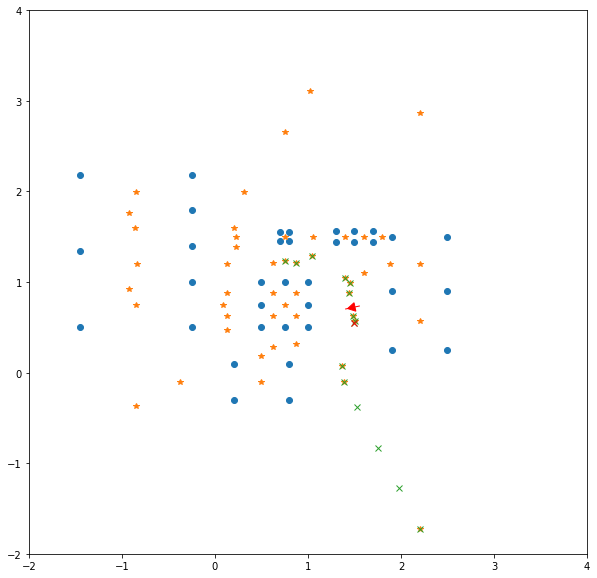

Step:  171
theta:-1.3970759307589817
e:0.15327622905943872 e_theta:1.5318332388641434
(v,omega): [[0.14   ]
 [0.76592]]
(x,y,theta) before: 1.468505639785329, 0.7201100473745847, 9.637461444736047
Clamped wheel Velocities: [[5.72169]
 [2.89369]] (0.2875804207129177, 0.33478981822472126)
(x,y,theta) after: 1.4549475789378798, 0.716633959222569, 9.714053106679254
[[0.07638]
 [0.76805]]
Robot speed boosted [[0.14   ]
 [0.76805]]
[[0.07615]
 [0.7702 ]]
Robot speed boosted [[0.14  ]
 [0.7702]]
[[0.07595]
 [0.77235]]
Robot speed boosted [[0.14   ]
 [0.77235]]
[[0.07579]
 [0.77448]]
Robot speed boosted [[0.14   ]
 [0.77448]]
[[0.07565]
 [0.77658]]
Robot speed boosted [[0.14   ]
 [0.77658]]
[[0.07554]
 [0.77864]]
Robot speed boosted [[0.14   ]
 [0.77864]]
[[0.07546]
 [0.78064]]
Robot speed boosted [[0.14   ]
 [0.78064]]
[[0.07541]
 [0.78258]]
Robot speed boosted [[0.14   ]
 [0.78258]]
[[0.07538]
 [0.78444]]
Robot speed boosted [[0.14   ]
 [0.78444]]
[[0.07538]
 [0.78621]]
Robot speed boosted [

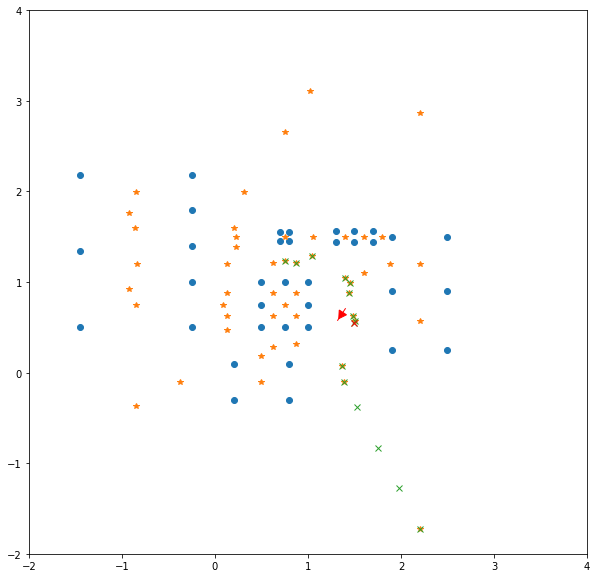

Step:  181
theta:-0.5811028112214273
e:0.15075618343177888 e_theta:1.572418902110325
(v,omega): [[0.14   ]
 [0.78621]]
(x,y,theta) before: 1.355728194779219, 0.6431778164001262, 10.41284890102742
Clamped wheel Velocities: [[5.75916]
 [2.85623]] (0.287093879295381, 0.33548616932416964)
(x,y,theta) after: 1.3484911911685797, 0.631197631131377, 10.491469846132937
[[0.0754 ]
 [0.78789]]
Robot speed boosted [[0.14   ]
 [0.78789]]
[[0.07545]
 [0.78947]]
Robot speed boosted [[0.14   ]
 [0.78947]]
[[0.07551]
 [0.79094]]
Robot speed boosted [[0.14   ]
 [0.79094]]
[[0.0756]
 [0.7923]]
Robot speed boosted [[0.14  ]
 [0.7923]]
[[0.07571]
 [0.79354]]
Robot speed boosted [[0.14   ]
 [0.79354]]
[[0.07583]
 [0.79466]]
Robot speed boosted [[0.14   ]
 [0.79466]]
[[0.07597]
 [0.79567]]
Robot speed boosted [[0.14   ]
 [0.79567]]
[[0.07612]
 [0.79656]]
Robot speed boosted [[0.14   ]
 [0.79656]]
[[0.07628]
 [0.79732]]
Robot speed boosted [[0.14   ]
 [0.79732]]
[[0.07645]
 [0.79797]]
Robot speed boosted [[0.

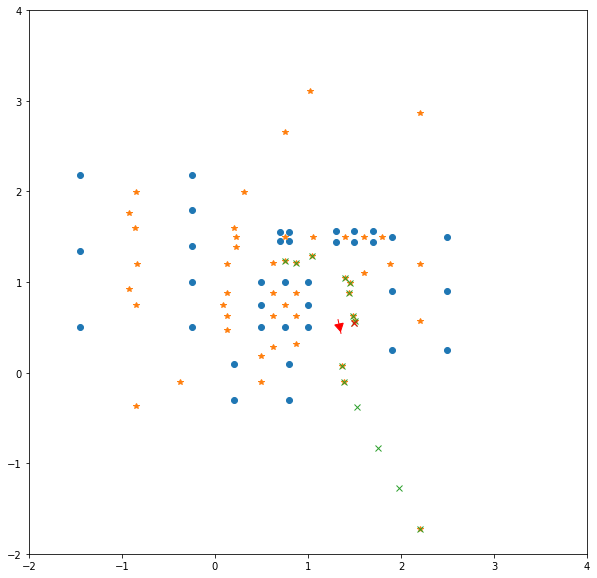

Step:  191
theta:0.2348751824894597
e:0.15289770564837835 e_theta:1.5959423944965572
(v,omega): [[0.14   ]
 [0.79797]]
(x,y,theta) before: 1.3303055563121873, 0.5092048514888765, 11.205303402352074
Clamped wheel Velocities: [[5.78087]
 [2.83451]] (0.286811879386655, 0.3358897751414913)
(x,y,theta) after: 1.3337632434430087, 0.49564238792335497, 11.285100522076903
[[0.07663]
 [0.7985 ]]
Robot speed boosted [[0.14  ]
 [0.7985]]
[[0.07682]
 [0.79892]]
Robot speed boosted [[0.14   ]
 [0.79892]]
[[0.07701]
 [0.79923]]
Robot speed boosted [[0.14   ]
 [0.79923]]
[[0.0772 ]
 [0.79944]]
Robot speed boosted [[0.14   ]
 [0.79944]]
[[0.0774 ]
 [0.79954]]
Robot speed boosted [[0.14   ]
 [0.79954]]
[[0.0776 ]
 [0.79955]]
Robot speed boosted [[0.14   ]
 [0.79955]]
[[0.0778 ]
 [0.79947]]
Robot speed boosted [[0.14   ]
 [0.79947]]
[[0.07799]
 [0.7993 ]]
Robot speed boosted [[0.14  ]
 [0.7993]]
[[0.07818]
 [0.79905]]
Robot speed boosted [[0.14   ]
 [0.79905]]
[[0.07837]
 [0.79873]]
Robot speed boosted [

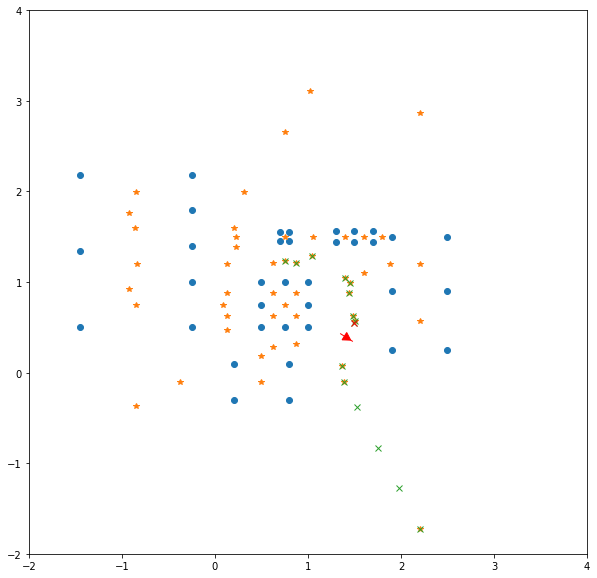

Step:  201
theta:1.035493788093494
e:0.15674579796317623 e_theta:1.5974632937888753
(v,omega): [[0.14   ]
 [0.79873]]
(x,y,theta) before: 1.408297820344714, 0.3974202857049879, 12.00440110866379
Clamped wheel Velocities: [[5.78227]
 [2.83311]] (0.2867936468277061, 0.33591587006786794)
(x,y,theta) after: 1.42042989652501, 0.39044113478391007, 12.084274273353234
[[0.07856]
 [0.79834]]
Robot speed boosted [[0.14   ]
 [0.79834]]
[[0.07874]
 [0.7979 ]]
Robot speed boosted [[0.14  ]
 [0.7979]]
[[0.07891]
 [0.7974 ]]
Robot speed boosted [[0.14  ]
 [0.7974]]
[[0.07907]
 [0.79685]]
Robot speed boosted [[0.14   ]
 [0.79685]]
[[0.07923]
 [0.79625]]
Robot speed boosted [[0.14   ]
 [0.79625]]
[[0.07937]
 [0.79563]]
Robot speed boosted [[0.14   ]
 [0.79563]]
[[0.07951]
 [0.79497]]
Robot speed boosted [[0.14   ]
 [0.79497]]
[[0.07964]
 [0.79428]]
Robot speed boosted [[0.14   ]
 [0.79428]]
[[0.07976]
 [0.79358]]
Robot speed boosted [[0.14   ]
 [0.79358]]
[[0.07987]
 [0.79286]]
Robot speed boosted [[0.

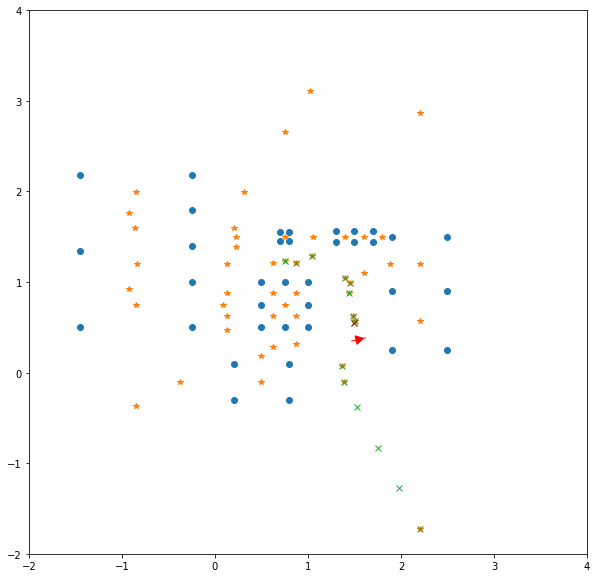

Step:  211
theta:1.8201528731470613
e:0.15974333570150034 e_theta:1.5857299315155924
(v,omega): [[0.14   ]
 [0.79286]]
(x,y,theta) before: 1.5428132209141816, 0.37525775314110105, 12.80079355599064
Clamped wheel Velocities: [[5.77144]
 [2.84394]] (0.2869343065152979, 0.33571455415811763)
(x,y,theta) after: 1.5562871879321434, 0.379045834091368, 12.88008005256642
[[0.07997]
 [0.79214]]
Robot speed boosted [[0.14   ]
 [0.79214]]
[[0.08006]
 [0.79141]]
Robot speed boosted [[0.14   ]
 [0.79141]]
[[0.08014]
 [0.79068]]
Robot speed boosted [[0.14   ]
 [0.79068]]
[[0.08021]
 [0.78996]]
Robot speed boosted [[0.14   ]
 [0.78996]]
[[0.08027]
 [0.78925]]
Robot speed boosted [[0.14   ]
 [0.78925]]
[[0.08032]
 [0.78855]]
Robot speed boosted [[0.14   ]
 [0.78855]]
[[0.08036]
 [0.78786]]
Robot speed boosted [[0.14   ]
 [0.78786]]
[[0.08039]
 [0.7872 ]]
Robot speed boosted [[0.14  ]
 [0.7872]]
[[0.08041]
 [0.78656]]
Robot speed boosted [[0.14   ]
 [0.78656]]
[[0.08042]
 [0.78594]]
Robot speed boosted 

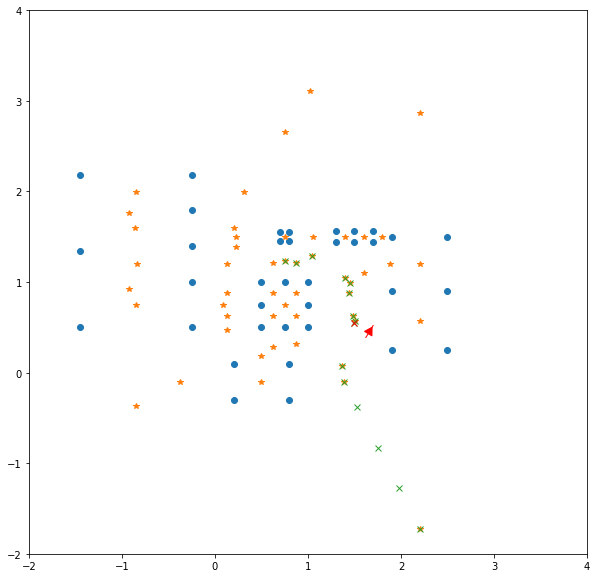

Step:  221
theta:2.5959504293029623
e:0.16083674596625366 e_theta:1.5718798912277379
(v,omega): [[0.14   ]
 [0.78594]]
(x,y,theta) before: 1.6530342750891713, 0.4555935478879853, 13.590441152434398
Clamped wheel Velocities: [[5.75866]
 [2.85673]] (0.28710034096430315, 0.3354769212106566)
(x,y,theta) after: 1.6598355670718221, 0.4678263544701635, 13.669035146995785
[[0.08042]
 [0.78535]]
Robot speed boosted [[0.14   ]
 [0.78535]]
[[0.08042]
 [0.78479]]
Robot speed boosted [[0.14   ]
 [0.78479]]
[[0.08041]
 [0.78426]]
Robot speed boosted [[0.14   ]
 [0.78426]]
[[0.08039]
 [0.78377]]
Robot speed boosted [[0.14   ]
 [0.78377]]
[[0.08036]
 [0.78331]]
Robot speed boosted [[0.14   ]
 [0.78331]]
[[0.08033]
 [0.78288]]
Robot speed boosted [[0.14   ]
 [0.78288]]
[[0.08029]
 [0.78249]]
Robot speed boosted [[0.14   ]
 [0.78249]]
[[0.08025]
 [0.78214]]
Robot speed boosted [[0.14   ]
 [0.78214]]
[[0.0802 ]
 [0.78183]]
Robot speed boosted [[0.14   ]
 [0.78183]]
[[0.08015]
 [0.78155]]
Robot speed boos

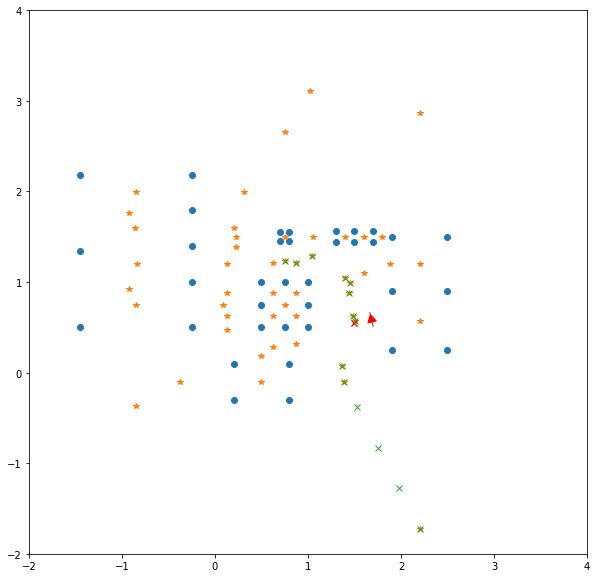

Step:  231
theta:-2.9123395366614724
e:0.1602930946589726 e_theta:1.5630981857016017
(v,omega): [[0.14   ]
 [0.78155]]
(x,y,theta) before: 1.6740320557555441, 0.5904135315895702, 14.374118199175683
Clamped wheel Velocities: [[5.75055]
 [2.86483]] (0.2872056161554256, 0.3353262485393474)
(x,y,theta) after: 1.670217510831151, 0.6038801384461612, 14.452273108460764
[[0.08009]
 [0.78131]]
Robot speed boosted [[0.14   ]
 [0.78131]]
[[0.08003]
 [0.7811 ]]
Robot speed boosted [[0.14  ]
 [0.7811]]
[[0.07997]
 [0.78093]]
Robot speed boosted [[0.14   ]
 [0.78093]]
[[0.07991]
 [0.7808 ]]
Robot speed boosted [[0.14  ]
 [0.7808]]
[[0.07984]
 [0.7807 ]]
Robot speed boosted [[0.14  ]
 [0.7807]]
[[0.07978]
 [0.78064]]
Robot speed boosted [[0.14   ]
 [0.78064]]
[[0.07971]
 [0.7806 ]]
Robot speed boosted [[0.14  ]
 [0.7806]]
[[0.07964]
 [0.7806 ]]
Robot speed boosted [[0.14  ]
 [0.7806]]
[[0.07958]
 [0.78063]]
Robot speed boosted [[0.14   ]
 [0.78063]]
[[0.07951]
 [0.78068]]
Robot speed boosted [[0.14  

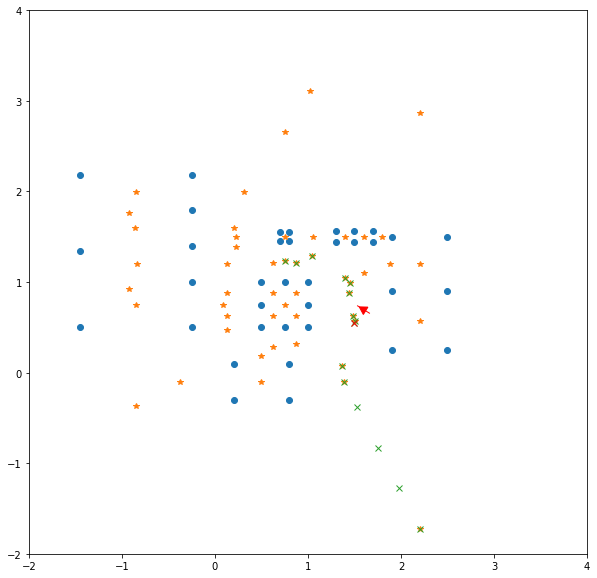

Step:  241
theta:-2.1331839394161705
e:0.15901726520174375 e_theta:1.561366626896831
(v,omega): [[0.14   ]
 [0.78068]]
(x,y,theta) before: 1.5939094443799442, 0.7008877007737784, 15.155005355225757
Clamped wheel Velocities: [[5.74895]
 [2.86643]] (0.2872263741031352, 0.33529653920898245)
(x,y,theta) after: 1.5817210277663782, 0.7077683238916925, 15.233073686570599
[[0.07944]
 [0.78076]]
Robot speed boosted [[0.14   ]
 [0.78076]]
[[0.07938]
 [0.78087]]
Robot speed boosted [[0.14   ]
 [0.78087]]
[[0.07932]
 [0.781  ]]
Robot speed boosted [[0.14 ]
 [0.781]]
[[0.07926]
 [0.78115]]
Robot speed boosted [[0.14   ]
 [0.78115]]
[[0.0792 ]
 [0.78131]]
Robot speed boosted [[0.14   ]
 [0.78131]]
[[0.07914]
 [0.7815 ]]
Robot speed boosted [[0.14  ]
 [0.7815]]
[[0.07909]
 [0.7817 ]]
Robot speed boosted [[0.14  ]
 [0.7817]]
[[0.07904]
 [0.78191]]
Robot speed boosted [[0.14   ]
 [0.78191]]
[[0.07899]
 [0.78213]]
Robot speed boosted [[0.14   ]
 [0.78213]]
[[0.07895]
 [0.78236]]
Robot speed boosted [[0.

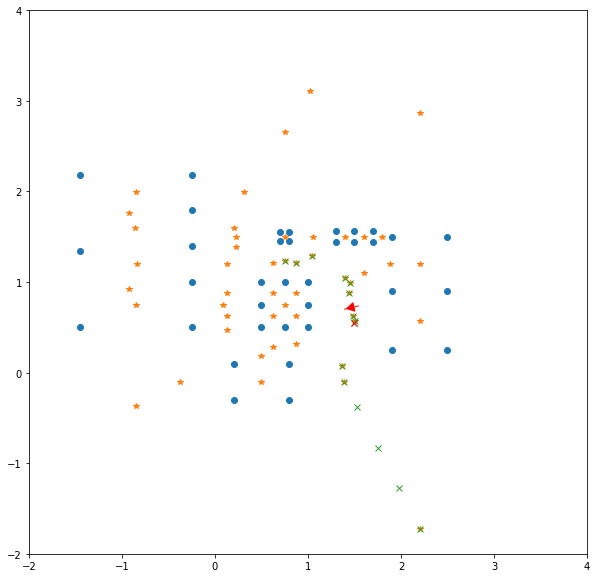

Step:  251
theta:-1.348520326243013
e:0.15789298640282598 e_theta:1.564729404610972
(v,omega): [[0.14   ]
 [0.78236]]
(x,y,theta) before: 1.459239533970182, 0.7229583859522727, 15.936306190684773
Clamped wheel Velocities: [[5.75206]
 [2.86333]] (0.287186061083585, 0.3353542362815728)
(x,y,theta) after: 1.4457407476073156, 0.7192593574735875, 16.01454266091532
[[0.07891]
 [0.7826 ]]
Robot speed boosted [[0.14  ]
 [0.7826]]
[[0.07887]
 [0.78285]]
Robot speed boosted [[0.14   ]
 [0.78285]]
[[0.07883]
 [0.7831 ]]
Robot speed boosted [[0.14  ]
 [0.7831]]
[[0.0788 ]
 [0.78335]]
Robot speed boosted [[0.14   ]
 [0.78335]]
[[0.07878]
 [0.7836 ]]
Robot speed boosted [[0.14  ]
 [0.7836]]
[[0.07875]
 [0.78385]]
Robot speed boosted [[0.14   ]
 [0.78385]]
[[0.07873]
 [0.7841 ]]
Robot speed boosted [[0.14  ]
 [0.7841]]
[[0.07872]
 [0.78434]]
Robot speed boosted [[0.14   ]
 [0.78434]]
[[0.0787 ]
 [0.78458]]
Robot speed boosted [[0.14   ]
 [0.78458]]
[[0.07869]
 [0.78481]]
Robot speed boosted [[0.14   

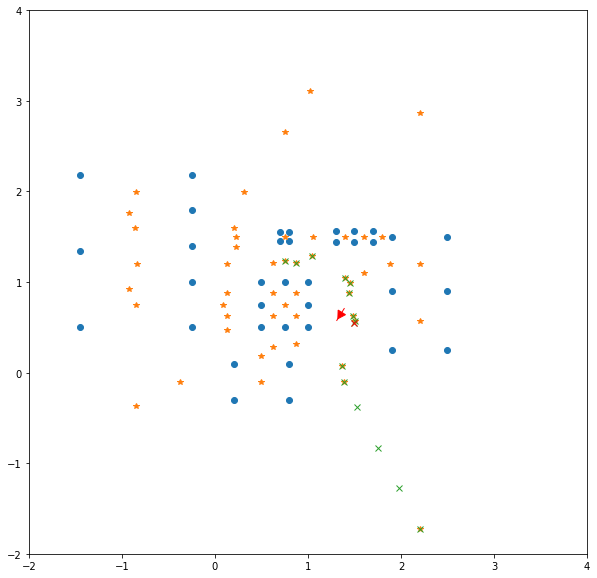

Step:  261
theta:-0.5601612953375931
e:0.1573879069428273 e_theta:1.569615341935858
(v,omega): [[0.14   ]
 [0.78481]]
(x,y,theta) before: 1.3481784676159305, 0.6436921297941909, 16.719779284265307
Clamped wheel Velocities: [[5.75657]
 [2.85882]] (0.28712748840836166, 0.335438067062097)
(x,y,theta) after: 1.3412270899555856, 0.63154397073591, 16.7982600513621
[[0.07869]
 [0.78503]]
Robot speed boosted [[0.14   ]
 [0.78503]]
[[0.07868]
 [0.78524]]
Robot speed boosted [[0.14   ]
 [0.78524]]
[[0.07868]
 [0.78545]]
Robot speed boosted [[0.14   ]
 [0.78545]]
[[0.07868]
 [0.78564]]
Robot speed boosted [[0.14   ]
 [0.78564]]
[[0.07869]
 [0.78582]]
Robot speed boosted [[0.14   ]
 [0.78582]]
[[0.0787]
 [0.786 ]]
Robot speed boosted [[0.14 ]
 [0.786]]
[[0.07871]
 [0.78615]]
Robot speed boosted [[0.14   ]
 [0.78615]]
[[0.07872]
 [0.7863 ]]
Robot speed boosted [[0.14  ]
 [0.7863]]
[[0.07873]
 [0.78643]]
Robot speed boosted [[0.14   ]
 [0.78643]]
[[0.07875]
 [0.78655]]
Robot speed boosted [[0.14   ]

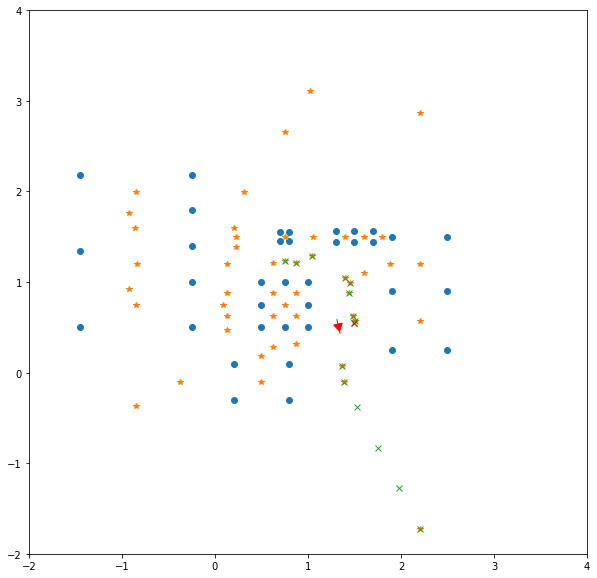

Step:  271
theta:0.2290160460182513
e:0.1574935260491104 e_theta:1.5731047398885387
(v,omega): [[0.14   ]
 [0.78655]]
(x,y,theta) before: 1.3255968650149703, 0.5091474131098639, 17.505467227668472
Clamped wheel Velocities: [[5.75979]
 [2.8556 ]] (0.28708565746387393, 0.33549793662948646)
(x,y,theta) after: 1.3292766316589009, 0.4956434029748723, 17.584122464662897
[[0.07876]
 [0.78666]]
Robot speed boosted [[0.14   ]
 [0.78666]]
[[0.07878]
 [0.78675]]
Robot speed boosted [[0.14   ]
 [0.78675]]
[[0.0788 ]
 [0.78683]]
Robot speed boosted [[0.14   ]
 [0.78683]]
[[0.07882]
 [0.7869 ]]
Robot speed boosted [[0.14  ]
 [0.7869]]
[[0.07884]
 [0.78695]]
Robot speed boosted [[0.14   ]
 [0.78695]]
[[0.07887]
 [0.787  ]]
Robot speed boosted [[0.14 ]
 [0.787]]
[[0.07889]
 [0.78703]]
Robot speed boosted [[0.14   ]
 [0.78703]]
[[0.07891]
 [0.78705]]
Robot speed boosted [[0.14   ]
 [0.78705]]
[[0.07893]
 [0.78705]]
Robot speed boosted [[0.14   ]
 [0.78705]]
[[0.07896]
 [0.78705]]
Robot speed boosted [[

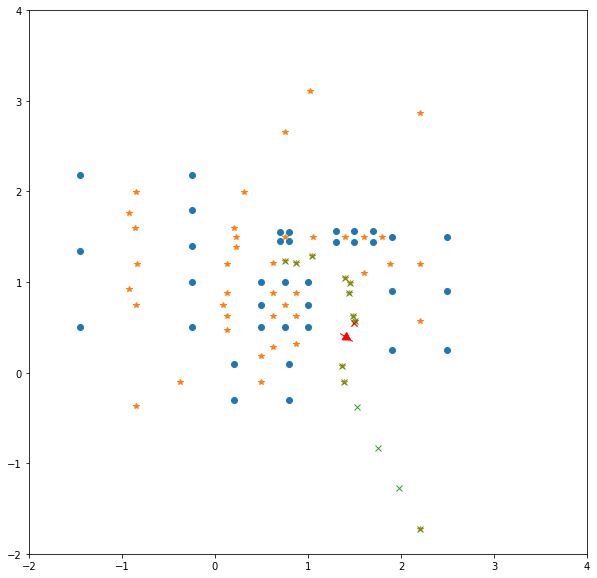

Step:  281
theta:1.0168897256782663
e:0.15791495254107227 e_theta:1.574100841200405
(v,omega): [[0.14   ]
 [0.78705]]
(x,y,theta) before: 1.4048703748360831, 0.3981294682172051, 18.29234480601662
Clamped wheel Velocities: [[5.76071]
 [2.85468]] (0.287073716189406, 0.3355150273011227)
(x,y,theta) after: 1.4170315723752176, 0.3912009677490777, 18.371049848076638
[[0.07898]
 [0.78704]]
Robot speed boosted [[0.14   ]
 [0.78704]]
[[0.079  ]
 [0.78701]]
Robot speed boosted [[0.14   ]
 [0.78701]]
[[0.07903]
 [0.78698]]
Robot speed boosted [[0.14   ]
 [0.78698]]
[[0.07905]
 [0.78694]]
Robot speed boosted [[0.14   ]
 [0.78694]]
[[0.07907]
 [0.7869 ]]
Robot speed boosted [[0.14  ]
 [0.7869]]
[[0.07909]
 [0.78684]]
Robot speed boosted [[0.14   ]
 [0.78684]]
[[0.07911]
 [0.78678]]
Robot speed boosted [[0.14   ]
 [0.78678]]
[[0.07913]
 [0.78672]]
Robot speed boosted [[0.14   ]
 [0.78672]]
[[0.07915]
 [0.78664]]
Robot speed boosted [[0.14   ]
 [0.78664]]
[[0.07916]
 [0.78657]]
Robot speed boosted [[

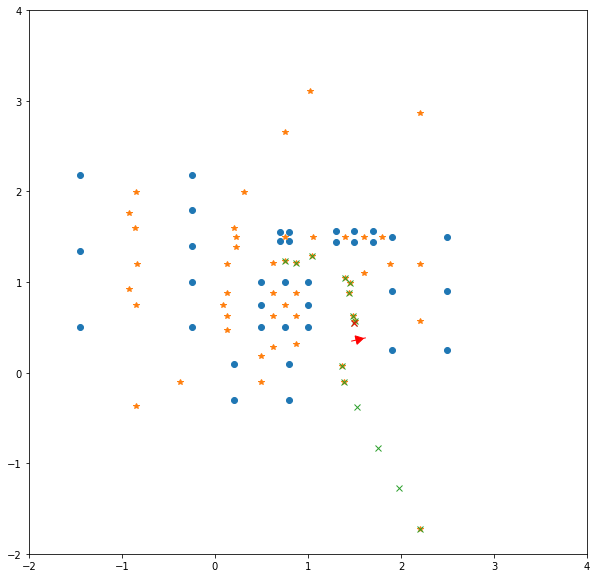

Step:  291
theta:1.8028200949201176
e:0.15832639335184415 e_theta:1.5731403569594242
(v,omega): [[0.14   ]
 [0.78657]]
(x,y,theta) before: 1.5394617919817155, 0.37589409570054266, 19.079235659499453
Clamped wheel Velocities: [[5.75982]
 [2.85556]] (0.2870852304860012, 0.33549854773164633)
(x,y,theta) after: 1.5529548023668502, 0.3796139933405981, 19.157892677347423
[[0.07918]
 [0.78649]]
Robot speed boosted [[0.14   ]
 [0.78649]]
[[0.07919]
 [0.78641]]
Robot speed boosted [[0.14   ]
 [0.78641]]
[[0.07921]
 [0.78633]]
Robot speed boosted [[0.14   ]
 [0.78633]]
[[0.07922]
 [0.78624]]
Robot speed boosted [[0.14   ]
 [0.78624]]
[[0.07923]
 [0.78616]]
Robot speed boosted [[0.14   ]
 [0.78616]]
[[0.07924]
 [0.78607]]
Robot speed boosted [[0.14   ]
 [0.78607]]
[[0.07925]
 [0.78598]]
Robot speed boosted [[0.14   ]
 [0.78598]]
[[0.07926]
 [0.7859 ]]
Robot speed boosted [[0.14  ]
 [0.7859]]
[[0.07926]
 [0.78582]]
Robot speed boosted [[0.14   ]
 [0.78582]]
[[0.07927]
 [0.78573]]
Robot speed boost

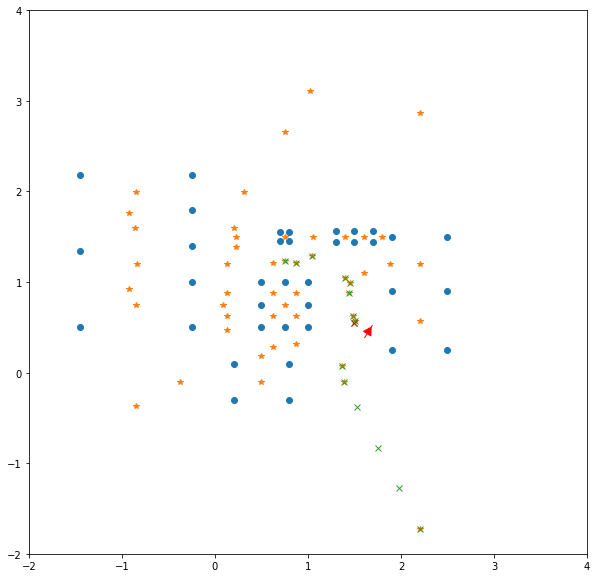

Step:  301
theta:2.587343057241013
e:0.1585384870751678 e_theta:1.5714662121067597
(v,omega): [[0.14   ]
 [0.78573]]
(x,y,theta) before: 1.650266571995438, 0.45547611473334015, 19.865432766673013
Clamped wheel Velocities: [[5.75828]
 [2.85711]] (0.2871053001545646, 0.33546982348481763)
(x,y,theta) after: 1.657167993276328, 0.4676527138845465, 19.944006077278353


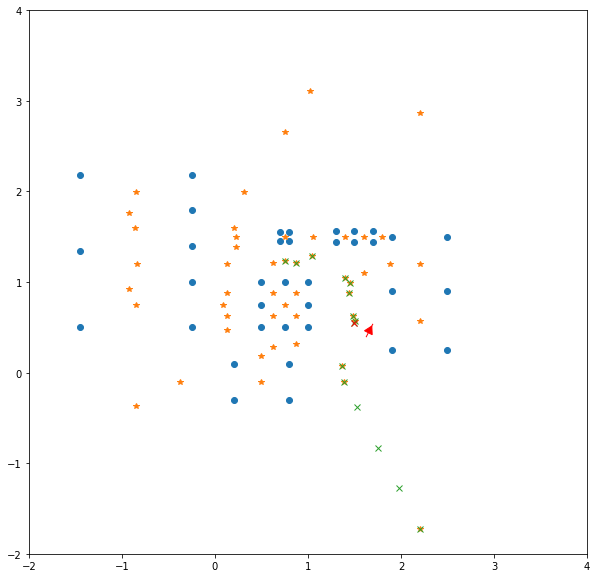

End of Trajectory!!!


In [125]:
# load control parameters 
num_iter = control_params["num_iter"]
interval = control_params["interval"]
motion = control_params["motion"]
debug = control_params["debug"]
speed_lower_limit = control_params["speed_lower"]
speed_upper_limit = control_params["speed_upper"]

# load robot parameters
wheel_radius = robot_params["wheel_radius"]
axle_length = robot_params["axle_length"]
dt = robot_params["motor_on_time"]
robot_pose = [robot_params["start_x"],robot_params["start_y"],robot_params["start_theta"]]
T = control2robot(wheel_radius, axle_length)

# load trajectory parameters
trajec_params["points"] = generate_trajectory(shortest, vor, 0.5, debug=True)
trajec_params["current"] = 0  # current points to trajectory's first pt

# Map parameters
display_param = {
    "figsize": (10,10),
    "xlim": [-2,4],
    "ylim": [-2,4]
    }

# the point in the trajectory closed to the robot is the pursuit point, update current
trajec_params["current"], pursuit_pt = closest_point(trajec_params,robot_pose)
pursuit_x = pursuit_pt[0]
pursuit_y = pursuit_pt[1]

K_v = pursuit_params['K_v']
K_i = pursuit_params['K_i']
K_h = pursuit_params['K_h']
lag = pursuit_params['lag']

robot_x = robot_pose[0]
robot_y = robot_pose[1]
robot_theta = robot_pose[2]
sum_errors = 0

""" Robot pursuit a moving point """
for i in range(num_iter):
    
    robot_pos = [robot_x ,robot_y]
    
    """ =================== """        
    """ Pursuit Following   """
    """ =================== """
    pursuit_pt = next_pursuit_pt(robot_pose, pursuit_pt, trajec_params)
    if pursuit_pt is None:
        break
    pursuit_x = pursuit_pt[0]
    pursuit_y = pursuit_pt[1]

    # PI Controller for v
    error_pos = distance(robot_pos,pursuit_pt)-lag
    v = K_v*error_pos + K_i*sum_errors  # P-componet
    sum_errors += error_pos  # I-Component

    # P Controller for omega
    theta = math.atan2((pursuit_y-robot_y),(pursuit_x-robot_x))
    error_theta =  normalize_angle(theta-robot_theta)  # critical to normalize angle!!!
    omega = K_h*error_theta
    
    robot_velocities = np.array([[v],[omega]])
    
    """ Clamp motor setting to (0.3-0.5) """
    inv_T = np.linalg.pinv(T)
    unclamped_velocities = np.dot(inv_T, robot_velocities)
    wheel_velocities = clamp(unclamped_velocities, speed_upper_limit, \
                                 speed_lower_limit, T, debug=True) 
    robot_velocities = np.dot(T, wheel_velocities)
    v = robot_velocities[0,0]
    omega = robot_velocities[1,0]
    
    """ Move robot """
    # Map wheel angular velocities to motor setting, then run motors 
    w_r = omega2speed(wheel_velocities[0,0],wheel_calibration) 
    w_l = omega2speed(wheel_velocities[1,0],wheel_calibration)
        
    if motion is True:
        robot.set_motors(w_l, w_r)  # left, right
        time.sleep(Rtime)
        robot.stop()
        
    # robot_velocities = (v,omega)
    d_x,d_y,d_theta = robot_pose_delta(v,omega,robot_theta,dt)

    if i%interval==0:
        animate_robot(robot_pose, points, vor, display_param, path=trajec_params["points"], pursuit_pt=pursuit_pt)
        print("Step: ", i+1)
        print("theta:{}".format(theta))
        print("e:{} e_theta:{}".format(error_pos, error_theta))
        print("(v,omega): {}".format(robot_velocities))
        print("(x,y,theta) before: {}, {}, {}".format(robot_x,robot_y,robot_theta))
        print("Clamped wheel Velocities:", wheel_velocities, (w_l, w_r))
    
    robot_x += d_x
    robot_y += d_y
    robot_theta += d_theta
    robot_pose = [robot_x,robot_y,robot_theta]
    
    if i%interval==0:
        print("(x,y,theta) after: {}, {}, {}".format(robot_x,robot_y,robot_theta))

animate_robot(robot_pose, points, vor, display_param, path=trajec_params["points"], pursuit_pt=pursuit_pt)
print("End of Trajectory!!!")

In [441]:
trajec_params["current"]

86